# Deep Learning Challenge
# Emotionserkennung mit CNN
## Michelle Rohrer

### Pakete laden

In [ ]:
import warnings
import os
import json
import pickle
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np
import wandb
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from src.model import BaselineCNN
from src.test_train import train_model
from setup_config import (
    get_device, 
    get_optimal_num_workers, 
    should_use_pin_memory)
from src.plots import(
    plot_class_distribution, 
    plot_sample_images,
    plot_cross_validation_results,
    plot_confusion_matrix)
from src.evaluation import (evaluate_model)

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")

WanDB Key erfolgreich geladen


### Daten laden und vorbereiten

**Datenquelle:** Die Daten wurden von Kaggle heruntergeladen (https://www.kaggle.com/datasets/msambare/fer2013)

**Datenbeschreibung:**
Die Daten bestehen aus 48x48 Pixel großen Graustufenbildern von Gesichtern. Die Gesichter wurden automatisch so ausgerichtet, dass sie mehr oder weniger zentriert sind und ungefähr den gleichen Bereich in jedem Bild einnehmen.

**Aufgabe:**
Jedes Gesicht soll anhand des im Gesichtsausdruck gezeigten Gefühls einer von sieben Kategorien zugeordnet werden:
- 0 = Angry (Wütend)
- 1 = Disgust (Ekel)
- 2 = Fear (Angst)
- 3 = Happy (Glücklich)
- 4 = Neutral (Neutral)
- 5 = Sad (Traurig)
- 6 = Surprise (Überrascht)

**Datensatz-Größe:**
- Trainingssatz: 28.709 Beispiele
- Testsatz: 7.178 Beispiele (laut Code-Ausgabe)

In [ ]:
# Pfade zu den Datenverzeichnissen
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

print(f"Daten-Verzeichnisse:")
print(f"  Training: {train_dir}")
print(f"  Test: {test_dir}")

Daten-Verzeichnisse:
  Training: data/train
  Test: data/test


In [ ]:
# Konfiguration für Bildverarbeitung
img_size = 48  # Alle Bilder werden auf 48x48 Pixel skaliert
batch_size = 32  # Anzahl Bilder pro Batch

# Bildtransformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Bilder auf 48x48 Pixel skalieren
    transforms.Grayscale(num_output_channels=1),  # Zu Graustufen konvertieren
    transforms.ToTensor()  # Zu PyTorch Tensor konvertieren (Werte 0-1)
])
print(f"Bildgröße: {img_size}x{img_size} Pixel, Batch-Größe: {batch_size}")

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen mit Multi-Core Optimierung
# Optimale Worker-Anzahl für Multi-Core
import multiprocessing
optimal_workers = get_optimal_num_workers()
print(f"Verwende {optimal_workers} Worker für DataLoader (von {multiprocessing.cpu_count()} Cores)")

# pin_memory nur für CUDA aktivieren (nicht für MPS oder CPU)
use_pin_memory = should_use_pin_memory()

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory  # Nur bei CUDA aktivieren
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=optimal_workers,
    pin_memory=use_pin_memory
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Bildgröße: 48x48 Pixel, Batch-Größe: 64
Verwende 9 Worker für DataLoader (von 10 Cores)
Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


#### Aufteilung in Trainings- und Validierungsdatensatz

Für die Entwicklung und Evaluation der Modelle wurde der Trainingsdatensatz in zwei separate Teilmengen aufgeteilt. Einen Trainingsdatensatz und einen Validierungsdatensatz im Verhältnis 80/20.

##### Begründung für die Aufteilung

Der Validierungsdatensatz ermöglicht es, die Leistung des Modells während des Trainingsprozesses auf bisher ungesehenen Daten zu evaluieren. Ohne diese Aufteilung bestünde eine höhere Gefahr des Overfittings, das Modell würde also die Trainingsdaten auswendig lernen, anstatt generalisierbare Muster zu erkennen. Der Validierungsdatensatz fungiert somit als unabhängige Kontrollinstanz, die frühzeitig Anzeichen von Overfitting aufdecken kann.

##### Die Wahl des 80/20-Verhältnisses

Das gewählte Verhältnis von 80% Trainings- und 20% Validierungsdaten hat sich in der Praxis bewährt und stellt einen ausgewogenen Kompromiss dar. Mit 80% der Daten für das Training steht dem Modell eine ausreichend grosse Datenmenge zur Verfügung, um robuste Muster zu lernen. Gleichzeitig sind 20% für die Validierung gross genug, um statistisch aussagekräftige Metriken zu liefern und die Generalisierungsfähigkeit zuverlässig zu bewerten.

### Expolorative Datenanalyse

#### Klassenverteilung

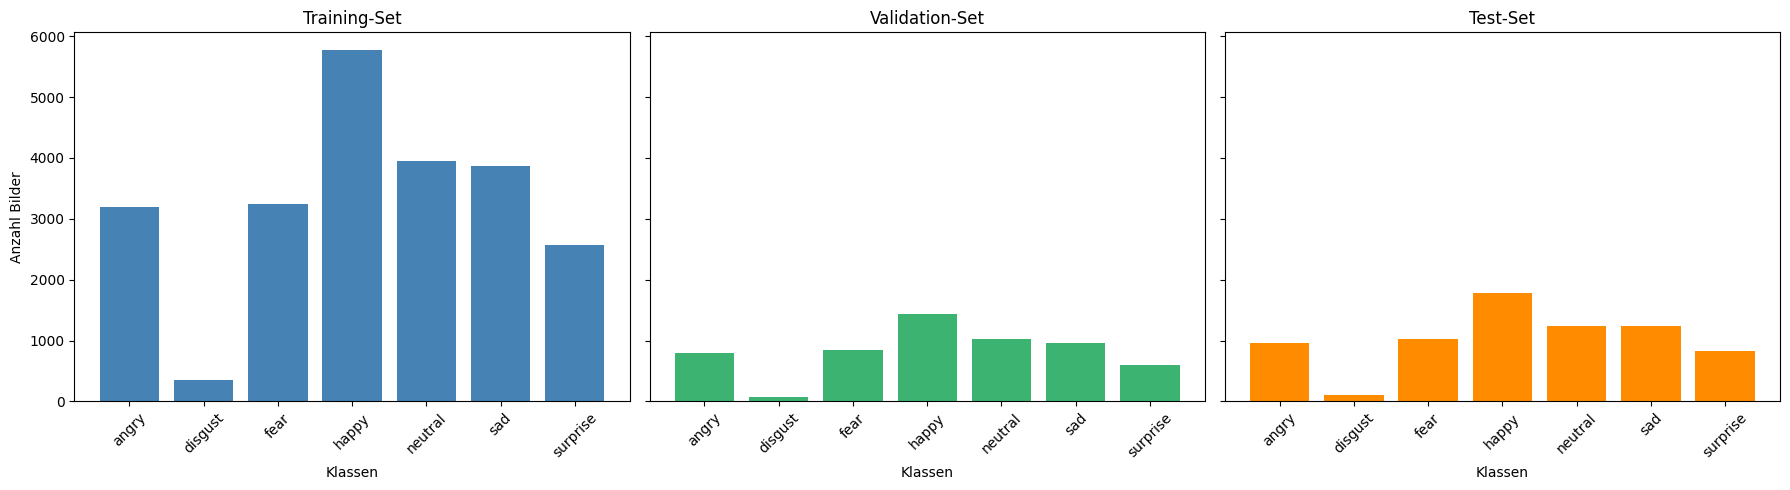

In [ ]:
plot_class_distribution(train_dataset, val_dataset, test_dataset)

***Auswertung:*** Die Analyse zeigt eine unbalancierte Verteilung der Klassen im Datensatz. Während *"happy"* mit Abstand am häufigsten vertreten ist, weist die Klasse *"disgust"* deutlich weniger Beispiele auf als alle anderen Kategorien. Diese Klassenungleichgewichte können die Modellperformance beeinflussen und müssen bei der Modellevaluation berücksichtigt werden.

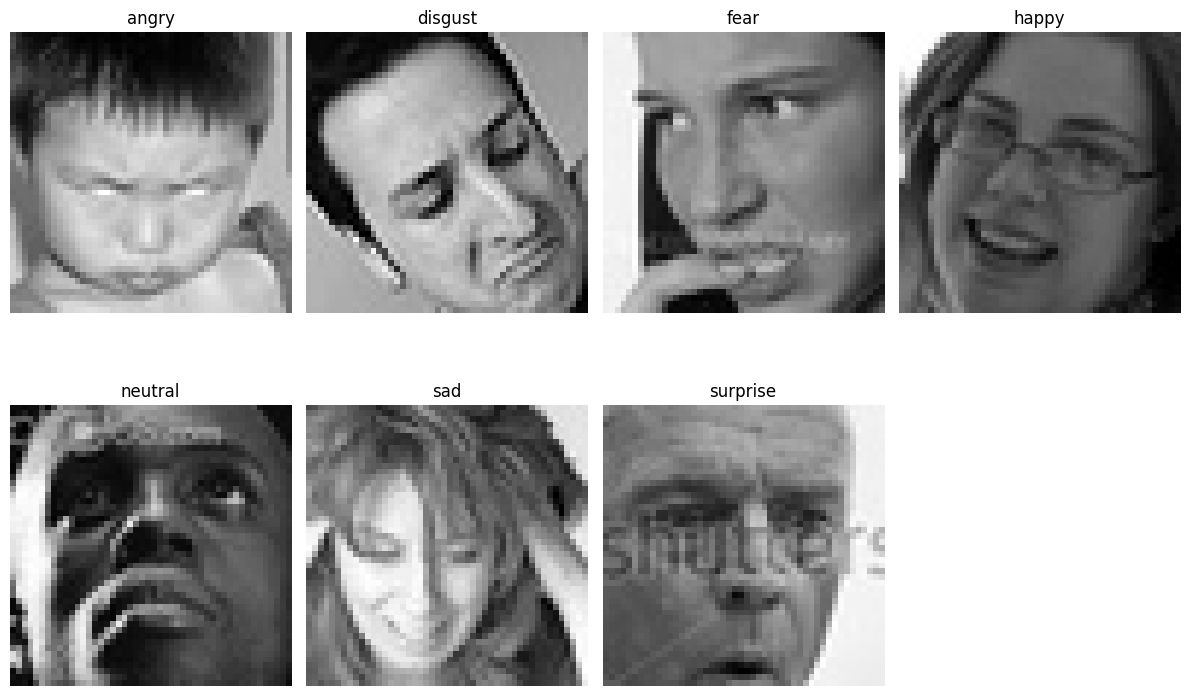

In [ ]:
fig = plot_sample_images(full_train_dataset)
plt.show()

***Auswertung:*** Bei der visuellen Analyse der Beispieldaten fällt auf, dass die Klassifikation der Gesichtsausdrücke subjektiv und nicht eindeutig ist. Verschiedene Personen in meinem Umfeld interpretierten die gezeigten Bilder unterschiedlich. Beispielsweise wurde das Bild der Kategorie "disgust" (Ekel) als selbstverliebt oder kritisch wahrgenommen. Diese Beobachtung unterstreicht die Herausforderung der Emotionserkennung, da Gesichtsausdrücke oft mehrdeutig sind und kulturell sowie individuell unterschiedlich interpretiert werden können.

### Überblick der Metriken

Für die Evaluation werden verschiedene Metriken eingesetzt, um die Modellperformance umfassend zu bewerten:

#### 1. **Konfusionsmatrix-basierte Metriken**

**Accuracy (Genauigkeit):**
Die Accuracy misst den Anteil der korrekt klassifizierten Samples an der Gesamtanzahl. Sie gibt einen ersten Überblick über die Gesamtleistung des Modells, ist jedoch bei unbalancierten Datensätzen wie dem FER-2013-Datensatz mit Vorsicht zu interpretieren.

**Precision (Präzision):**
Die Precision für jede Klasse misst, wie viele der als Klasse X vorhergesagten Samples tatsächlich zur Klasse X gehören. Diese Metrik ist besonders wichtig, um False Positives zu identifizieren.

**Recall (Sensitivität):**
Der Recall misst, wie viele Samples einer bestimmten Klasse korrekt erkannt wurden. Diese Metrik ist entscheidend, um zu verstehen, wie gut das Modell seltene Klassen (wie "disgust") erkennt.

#### 2. **F1-Score**

Der F1-Score kombiniert Precision und Recall zu einer einzigen Metrik und stellt das harmonische Mittel dar. Er ist besonders wertvoll bei unbalancierten Datensätzen, da er sowohl False Positives als auch False Negatives berücksichtigt.

#### 3. **Top-K Accuracy**

Die Top-K Accuracy misst, ob die korrekte Klasse unter den K wahrscheinlichsten Vorhersagen liegt. Dies ist besonders relevant für Emotionserkennung, da ähnliche Emotionen (z.B. "fear" und "surprise") oft verwechselt werden können.

#### 4. **Cross-Validation**

Die Verwendung von Cross-Validation ermöglicht eine robustere Evaluation, indem das Modell auf verschiedenen Datenaufteilungen trainiert und getestet wird. Dies reduziert die Varianz der Ergebnisse und gibt eine zuverlässigere Einschätzung der Generalisierungsfähigkeit.

Diese umfassende Metrikenauswahl ermöglicht es, sowohl die Gesamtleistung als auch die spezifischen Stärken und Schwächen des Modells in verschiedenen Emotionskategorien zu bewerten.

### Baseline-Modell

#### Architektur des Baseline-CNN

**Wo ist die Architektur definiert:** Die Modell-Architektur ist in `src/model.py` definiert (Klasse `BaselineCNN`).

**Architektur-Übersicht:**
Als Basismodell wird ein einfaches Convolutional Neural Network verwendet. Die Architektur besteht aus drei aufeinanderfolgenden Convolutional Blocks, gefolgt von zwei Fully Connected Layers für die Klassifikation.

**Feature Extraction (Convolutional Blocks):**
Der Feature-Extraction-Teil umfasst drei Convolutional Blocks mit steigender Filterzahl:
- **Block 1:** 16 Filter, 3×3 Kernel, ReLU, MaxPooling 2×2
- **Block 2:** 32 Filter, 3×3 Kernel, ReLU, MaxPooling 2×2
- **Block 3:** 64 Filter, 3×3 Kernel, ReLU, MaxPooling 2×2

Jeder Block besteht aus:
- Convolutional Layer mit 3×3 Kernel-Größe
- ReLU-Aktivierungsfunktion
- Max-Pooling-Layer mit 2×2 Kernel (reduziert Bildgröße um Faktor 2)

**Klassifikation (Fully Connected Layers):**
- **Layer 1:** 64 Neuronen (von 64×6×6 = 2304 Features)
- **Layer 2:** 7 Neuronen (eine pro Emotion)
- **Output:** Keine explizite Aktivierungsfunktion, da `CrossEntropyLoss` in PyTorch implizit Softmax anwendet

**Training-Konfiguration (wird im training.ipynb verwendet):**
- **Optimizer:** Stochastic Gradient Descent (SGD) ohne Momentum
- **Learning Rate:** 0.01
- **Batch Size:** 64
- **Epochen:** 60 (Epoche 60 dient als Referenzpunkt)

In [ ]:
# Modell-Architektur anzeigen und Device Setup
print("=== Modell-Architektur und Device Setup ===")

# Anzahl Klassen und Klassennamen bestimmen
num_classes = len(full_train_dataset.class_to_idx)
class_names = list(full_train_dataset.class_to_idx.keys())
print(f"Anzahl Klassen: {num_classes}")
print(f"Klassennamen: {class_names}")

# Device Setup: MPS (Apple Silicon) > CUDA > CPU
device = torch.device("mps" if torch.backends.mps.is_available() 
                     else "cuda" if torch.cuda.is_available() 
                     else "cpu")

# Test-Modell für Architektur-Übersicht erstellen
# Dieses Modell wird nur für die Architektur-Anzeige verwendet, nicht für Training
print("\n=== Modell-Architektur-Übersicht ===")
test_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Summary anzeigen (zeigt alle Layer, Parameter-Anzahl, etc.)
summary(test_model, input_size=(1, img_size, img_size))

=== Modell-Architektur und Device Setup ===
Anzahl Klassen: 7
Klassennamen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Verwende Device: mps
  → Apple Silicon (MPS) - GPU-Beschleunigung aktiviert

=== Modell-Architektur-Übersicht ===


: 

#### Overfitting-Test

**Wo wird das gemacht:** Dieser Test wird **hier in main.ipynb** durchgeführt, **bevor** das vollständige Training startet.

**Zielsetzung und Begründung:**
Vor dem Training auf dem vollständigen Datensatz ist es essentiell zu verifizieren, dass das Modell überhaupt in der Lage ist zu lernen. Der Overfitting-Test ist eine Absicherung, bei dem das Modell absichtlich auf einer minimalen Datenmenge (nur 1 Batch) trainiert wird, um zu überprüfen, ob:
- Die Modellarchitektur korrekt implementiert ist
- Forward- und Backward-Passes funktionieren
- Die Gradientenberechnung korrekt ist
- Das Modell grundsätzlich lernen kann

**Methode:**
1. Ein DataLoader mit nur 1 Batch wird erstellt
2. Der Trainingsloop erkennt automatisch, dass es sich um einen Overfitting-Test handelt (wenn `len(train_loader) == 1`)
3. Das Modell wird auf diesem einzelnen Batch trainiert
4. Wenn das Modell den Batch perfekt lernen kann (Accuracy nahe 100%), ist die grundlegende Lernfähigkeit bestätigt

**Hinweis:** Das vollständige Training, Hyperparameter-Tuning und Cross-Validation werden im separaten Notebook `training.ipynb` durchgeführt. Dieses Notebook (`main.ipynb`) lädt die trainierten Modelle und zeigt die Ergebnisse.

In [ ]:
# Overfitting-Test: DataLoader mit nur 1 Batch erstellen
print("=== Overfitting-Test ===")
print("Erstelle DataLoader mit nur 1 Batch für Overfitting-Test...")

# Einen Batch aus dem Trainingsdatensatz holen
single_batch_images, single_batch_labels = next(iter(train_loader))

# DataLoader mit nur diesem einen Batch erstellen
from torch.utils.data import TensorDataset
single_batch_dataset = TensorDataset(single_batch_images, single_batch_labels)
single_batch_loader = DataLoader(single_batch_dataset, batch_size=len(single_batch_images), shuffle=False)

print(f"Overfitting-Test Batch-Größe: {len(single_batch_images)}")
print("Der Trainingsloop erkennt automatisch, dass es sich um einen Overfitting-Test handelt.\n")

# Neues Modell für Overfitting-Test (aus Code initialisiert)
overfit_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Training durchführen - train_model erkennt automatisch Overfitting-Test
train_losses_overfit, val_losses_overfit, train_accs_overfit, val_accs_overfit, train_f1s_overfit, val_f1s_overfit = train_model(
    model=overfit_model,
    device=device,
    train_loader=single_batch_loader,  # Nur 1 Batch -> Overfitting-Test wird automatisch erkannt
    val_loader=val_loader,
    num_epochs=500,  # Mehr Epochen für Overfitting-Test
    learning_rate=0.1,  # Höhere Lernrate für schnelleres Lernen
    batch_size=len(single_batch_images),
    use_wandb=False,  # Kein wandb für Overfitting-Test
    early_stopping=False  # Kein Early Stopping für Overfitting-Test
)

print(f"\n=== Overfitting-Test Ergebnisse ===")
print(f"Finale Train Accuracy: {train_accs_overfit[-1]:.2f}%")
print(f"Finale Train F1-Score: {train_f1s_overfit[-1]:.4f}")
print(f"Finale Train Loss: {train_losses_overfit[-1]:.4f}")

=== Overfitting-Test ===
Erstelle DataLoader mit nur 1 Batch für Overfitting-Test...
Overfitting-Test Batch-Größe: 64
Der Trainingsloop erkennt automatisch, dass es sich um einen Overfitting-Test handelt.

OVERFITTING-TEST MODUS: Train_loader enthält nur 1 Batch
Das Modell wird auf einem einzelnen Batch trainiert, um zu testen,
ob es in der Lage ist, die Daten perfekt zu lernen (Overfitting-Test).
Training startet: 500 Epochen, LR=0.1, Batch=64
------------------------------------------------------------
Epoch   1/500 | Train Loss: 1.9577 | Val Loss: 1.9436 | Train Acc: 0.00% | Val Acc: 25.06%


: 

***Auswertung:*** 

Das Modell erreicht nach etwa 250-280 Epochen eine Accuracy von 100% auf dem einzelnen Batch, was bestätigt, dass:
- Die Modellarchitektur korrekt implementiert ist
- Forward- und Backward-Passes funktionieren
- Die Gradientenberechnung korrekt ist
- Das Modell grundsätzlich lernen kann

Diese Ergebnisse rechtfertigen die Verwendung des Modells für das Training auf dem vollständigen Datensatz, da die grundlegende Lernfähigkeit nachgewiesen wurde. Ein erfolgreicher Overfitting-Test zeigt, dass das Modell nicht auswendig lernt, sondern tatsächlich in der Lage ist, Muster zu erkennen und zu lernen.

#### Laden der trainierten Modelle

**Wo wird das Training gemacht:** Das Training des Basismodells, Hyperparameter-Tuning und Cross-Validation werden im separaten Notebook `training.ipynb` durchgeführt.

**Warum getrennt:**
Diese Trennung ermöglicht es, das Training einmal durchzuführen und dann in diesem Notebook (`main.ipynb`) die Ergebnisse zu laden und zu analysieren, ohne das Training jedes Mal neu durchführen zu müssen. Das macht `main.ipynb` schnell und fokussiert auf die Analyse der Ergebnisse.

**Was wurde im training.ipynb trainiert:**
- **Basismodell:** SGD (momentum=0), LR=0.01, Batch=64, 60 Epochen
  - Modell wird automatisch nach Epoche 60 gespeichert: `models/baseline_model_epoch60.pth`
  - Finales Modell wird gespeichert: `models/baseline_model.pth`
- **Hyperparameter-Tuning:** Vergleich verschiedener Lernraten [0.001, 0.01, 0.1] und Batch-Größen [16, 32, 64]
  - Ergebnisse werden als Plots gespeichert: `plots/hyperparameter_comparison.png` und `plots/hyperparameter_performance_summary.png`
- **Cross-Validation:** 5-Fold Cross-Validation mit besten Hyperparametern
  - Ergebnisse werden gespeichert: `results/cross_validation_results.json`

**Wie wird das Modell geladen:**
1. **Modell-Architektur aus Code initialisieren:** `BaselineCNN(img_size=img_size, num_classes=num_classes)`
   - Dies stellt sicher, dass die Architektur exakt mit dem Training übereinstimmt
2. **Trainierte Gewichte laden:** `load_state_dict(torch.load(...))`
   - Die trainierten Gewichte werden aus der `.pth` Datei geladen
3. **Modell in Evaluation-Modus setzen:** `model.eval()`
   - Deaktiviert Dropout und BatchNorm-Updates für konsistente Evaluation

**Wichtig:** Das Modell wird **nicht** komplett geladen, sondern die Architektur wird aus Code erstellt und nur die Gewichte werden geladen. Dies ist der korrekte und empfohlene Ansatz.

In [ ]:
# Laden der trainierten Modelle
# Prüfen ob Modelle existieren
models_dir = "models"
if os.path.exists(models_dir):
    model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]
    print(f"Gefundene Modell-Dateien: {model_files}")
else:
    print("Models-Verzeichnis nicht gefunden.")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")

# Basismodell laden
print("\n=== Laden des Basismodells ===")
print("Modell wird aus Code initialisiert (Architektur) und trainierten Gewichte werden geladen.")

baseline_model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Prüfen ob Modell-Datei existiert
model_path = os.path.join(models_dir, "baseline_model.pth")
if os.path.exists(model_path):
    baseline_model.load_state_dict(torch.load(model_path, map_location=device))
    baseline_model.eval()  # Setze Modell in Evaluation-Modus
    print(f"Basismodell erfolgreich geladen von: {model_path}")
    print("Modell ist bereit für Evaluation.")
else:
    print(f"WARNUNG: Modell-Datei nicht gefunden: {model_path}")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")

Gefundene Modell-Dateien: ['baseline_model_epoch60.pth', 'baseline_model.pth']

=== Laden des Basismodells ===
Modell wird aus Code initialisiert (Architektur) und trainierten Gewichte werden geladen.
Basismodell erfolgreich geladen von: models/baseline_model.pth
Modell ist bereit für Evaluation.


=== Lernkurven des Basismodells ===


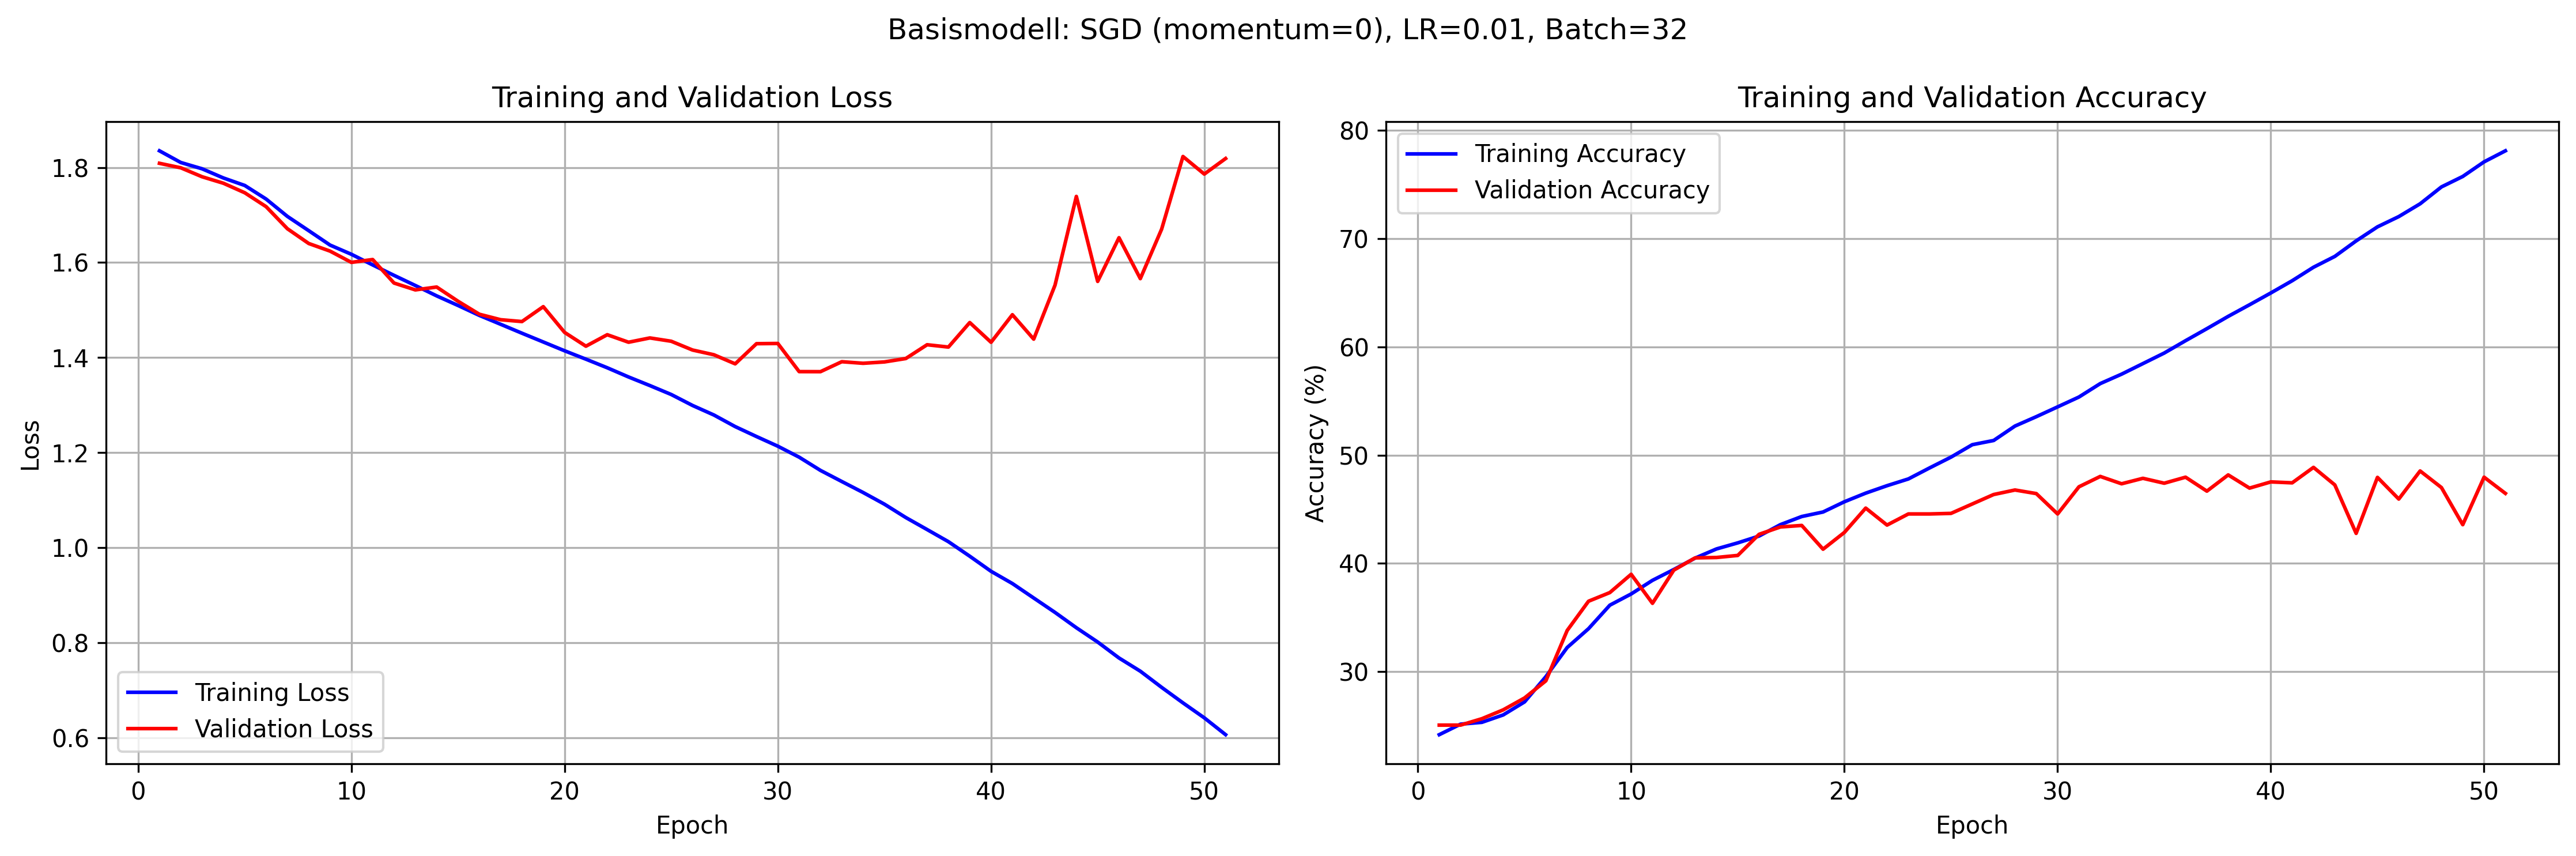

Lernkurven geladen von: plots/baseline_training_curves.png


In [ ]:
# Lernkurven des Basismodells anzeigen
# Prüfen ob das Plot-Bild existiert
print("=== Lernkurven des Basismodells ===")
plot_path = "plots/baseline_training_curves.png"
if os.path.exists(plot_path):
    display(Image(filename=plot_path))
    print(f"Lernkurven geladen von: {plot_path}")
else:
    print(f"Plot-Bild nicht gefunden unter: {plot_path}")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")

#### Analyse der Lernkurven

**Wo wurden die Lernkurven erstellt:** Die Lernkurven wurden während des Trainings im `training.ipynb` erstellt und als Bild gespeichert (`plots/baseline_training_curves.png`). Hier werden sie nur angezeigt.

**Was zeigen die Lernkurven:**
Die Lernkurven zeigen den Verlauf von Training und Validation Loss sowie Accuracy während des Trainingsprozesses über alle Epochen. Sie sind wichtig, um:
- Den Trainingsfortschritt zu visualisieren
- Overfitting zu erkennen (Divergenz zwischen Train und Val)
- Den optimalen Stopp-Zeitpunkt zu bestimmen
- Die Konvergenz des Modells zu beurteilen

***Auswertung der Lernkurven:*** 

Die Lernkurven des Basismodells zeigen typische Muster eines einfachen Modells ohne Regularisierung:

**Training vs. Validation Loss:**
- Der Training Loss sinkt kontinuierlich über die Epochen
- Der Validation Loss zeigt Anzeichen von Overfitting (steigt nach einem bestimmten Punkt an oder stagniert)
- Die Divergenz zwischen Training und Validation Loss ist ein klassisches Overfitting-Signal

**Training vs. Validation Accuracy:**
- Die Training Accuracy steigt stetig
- Die Validation Accuracy stagniert oder verbessert sich nur langsam
- Der große Abstand zwischen Training und Validation Accuracy bestätigt Overfitting

Das Modell lernt die Trainingsdaten sehr gut, kann aber nicht optimal auf neue Daten generalisieren. Dies ist zu erwarten bei einem einfachen Basismodell ohne Regularisierungstechniken.

#### Evaluation des Basismodells auf Test-Daten

**Wo wird das gemacht:** Die Evaluation wird **hier in main.ipynb** durchgeführt, nachdem das Modell geladen wurde.

**Was wird gemacht:**
Das trainierte Basismodell wird auf dem Test-Datensatz evaluiert, um die finale Performance zu messen. Der Test-Datensatz wurde während des Trainings **nicht** verwendet und stellt daher die beste Schätzung der Generalisierungsfähigkeit dar.

**Berechnete Metriken:**
- **Accuracy:** Anteil korrekt klassifizierter Bilder
- **Precision (weighted/macro):** Präzision über alle Klassen
- **Recall (weighted/macro):** Sensitivität über alle Klassen
- **F1-Score (weighted/macro):** Harmonisches Mittel aus Precision und Recall
- **Top-2 Accuracy:** Anteil, bei dem die richtige Klasse unter den Top-2 Vorhersagen ist
- **Confusion Matrix:** Detaillierte Aufschlüsselung der Klassifikationsfehler

In [ ]:
# Detaillierte Evaluation des Basismodells auf Test-Daten
print("=== Evaluation des Basismodells auf Test-Daten ===")

# Test-Set Evaluation
test_results = evaluate_model(baseline_model, device, test_loader, class_names, 
                            use_wandb=False, run_name="baseline_evaluation")

print(f"\n=== Test-Ergebnisse ===")
print(f"Test Accuracy: {test_results['accuracy']:.4f} ({test_results['accuracy']*100:.2f}%)")
print(f"Precision (weighted): {test_results['precision_weighted']:.4f}")
print(f"Recall (weighted): {test_results['recall_weighted']:.4f}")
print(f"F1-Score (weighted): {test_results['f1_weighted']:.4f}")
print(f"Precision (macro): {test_results['precision_macro']:.4f}")
print(f"Recall (macro): {test_results['recall_macro']:.4f}")
print(f"F1-Score (macro): {test_results['f1_macro']:.4f}")
print(f"Top-2 Accuracy: {test_results['top2_accuracy']:.4f} ({test_results['top2_accuracy']*100:.2f}%)")

# Konfusionsmatrix plotten
fig = plot_confusion_matrix(
    confusion_matrix=test_results['confusion_matrix'],
    class_names=class_names,
    title='Konfusionsmatrix - Basismodell'
)
plt.show()

=== Evaluation des Basismodells auf Test-Daten ===


***Auswertung:*** Die Evaluationsergebnisse des Basismodells zeigen einige stärken und schwächen des Modells für die Emotionserkennung:

**Allgemeine Performance:**
- Test Accuracy: 48.45%: Das Modell klassifiziert nur etwa die Hälfte der Testbilder korrekt
- F1-Score (macro): 45.42%: Niedrige durchschnittliche Performance über alle Klassen
- Top-2 Accuracy: 67.23% Deutlich höher als Top-1, zeigt dass das Modell oft "nahe dran" ist

**Problematische Aspekte:**
- Niedrige Gesamtleistung bestätigt das in den Lernkurven beobachtete Overfitting
- Ungleichgewichtige Klassifikation zwischen verschiedenen Emotionen
- Schwierigkeiten bei der Unterscheidung ähnlicher Emotionen (z.B. angry vs. fear vs. sad)

**Positive Aspekte:**
- **Top-2 Accuracy deutlich höher: Das Modell hat oft die richtige Antwort unter den Top-2 Vorhersagen
- Grundlegende Lernfähigkeit vorhanden, aber Generalisierung unzureichend

Das Basismodell zeigt die erwarteten Schwächen eines einfachen Modells ohne Regularisierung. Die niedrige Accuracy und die Verwechslungen zwischen ähnlichen Emotionen unterstreichen die Notwendigkeit für verbesserte Architekturen und Regularisierungstechniken. Jedoch zeigen sich auch bereits positive Ansätze des Modells, insbesondere die deutlich höhere Top-2 Accuracy und die grundlegende Lernfähigkeit, die als solide Grundlage für weitere Verbesserungen dienen. Positive Emotionen (Happy, Surprise) können deutlich besser erkannt werden als negative Emotionen (Disgust, Fear, Sad, Angry). Dies könnte auf die Datenverteilung oder die visuellen Eigenschaften dieser Emotionen zurückzuführen sein.

#### Hyperparameter-Tuning Ergebnisse

**Wo wurde das Hyperparameter-Tuning durchgeführt:** Im Notebook `training.ipynb` (Cell 9-12).

**Was wurde gemacht:**
Systematischer Vergleich verschiedener Hyperparameter-Kombinationen, um die optimale Konfiguration zu finden. Für jede Kombination wurde ein neues Modell trainiert und die Performance verglichen.

**Testkonfigurationen die getestet wurden:**
- **Lernraten:** [0.001, 0.01, 0.1] - 3 verschiedene Werte
- **Batch-Größen:** [16, 32, 64] - 3 verschiedene Werte
- **Gesamt:** 3 × 3 = 9 verschiedene Konfigurationen
- **Epochen:** 60 (konsistent mit Baseline-Training)
- **Optimizer:** SGD ohne Momentum

**Methode:**
1. Für jede Kombination (LR × Batch) wurde ein neues Modell aus Code initialisiert
2. Die Modell-Klasse (`BaselineCNN`) wurde als Parameter übergeben (nicht hardcodiert)
3. Jedes Modell wurde 60 Epochen trainiert
4. Trainings- und Validierungskurven wurden aufgezeichnet
5. Beste Performance pro Konfiguration wurde identifiziert
6. Ergebnisse wurden als Plots gespeichert: `plots/hyperparameter_comparison.png` und `plots/hyperparameter_performance_summary.png`

**Wo werden die Ergebnisse angezeigt:** Hier in `main.ipynb` werden die gespeicherten Plots angezeigt und die beste Konfiguration aus den Cross-Validation-Ergebnissen geladen.

== Ergebnisse des Hyperparameter-Tunings ==


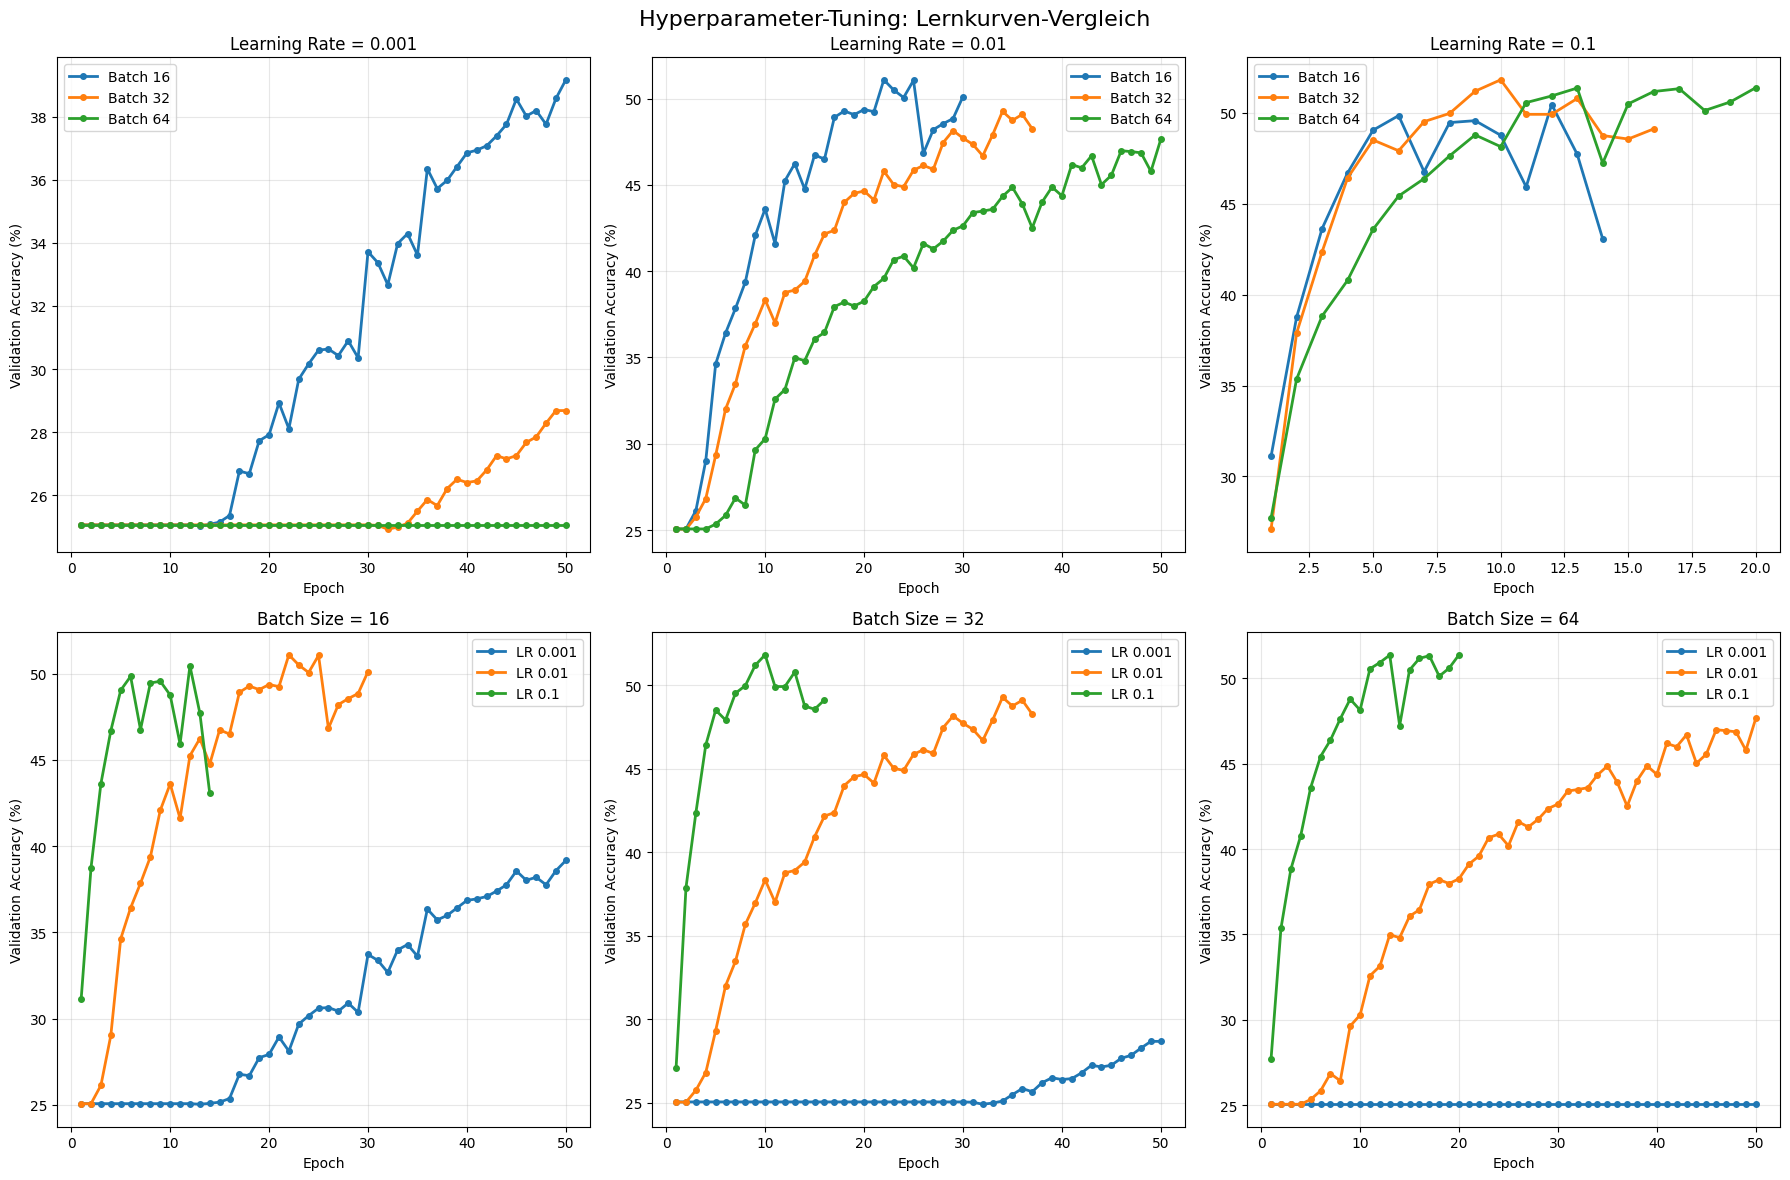

Beste Hyperparameter: LR=0.1, Batch=64


In [ ]:
# Ergebnisse des Hyperparameter-Tunings anzeigen
print("=== Ergebnisse des Hyperparameter-Tunings ===")

# Prüfen ob Plot-Bilder existieren
plot_path_comparison = "plots/hyperparameter_comparison.png"
plot_path_performance = "plots/hyperparameter_performance_summary.png"

if os.path.exists(plot_path_comparison):
    print("Hyperparameter-Vergleich (Lernkurven):")
    display(Image(filename=plot_path_comparison))
else:
    print(f"Plot-Bild nicht gefunden: {plot_path_comparison}")
    print("Bitte führen Sie zuerst das Hyperparameter-Tuning in 'training.ipynb' durch.")

if os.path.exists(plot_path_performance):
    print("\nHyperparameter-Performance-Übersicht:")
    display(Image(filename=plot_path_performance))
else:
    print(f"Plot-Bild nicht gefunden: {plot_path_performance}")

# Beste Hyperparameter aus Cross-Validation-Ergebnissen laden
results_dir = "results"
cv_results_file = os.path.join(results_dir, "cross_validation_results.json")
if os.path.exists(cv_results_file):
    with open(cv_results_file, 'r') as f:
        cv_results = json.load(f)
    best_lr = cv_results['best_hyperparameters']['learning_rate']
    best_batch = cv_results['best_hyperparameters']['batch_size']
    print(f"\nBeste Hyperparameter (aus Cross-Validation): LR={best_lr}, Batch={best_batch}")
else:
    print(f"\nCross-Validation-Ergebnisse nicht gefunden: {cv_results_file}")
    print("Bitte führen Sie zuerst das Training in 'training.ipynb' durch.")

***Auswertung:*** Das Hyperparameter-Tuning zeigt deutliche Unterschiede in der Performance verschiedener Konfigurationen:

**Lernrate 0.001:**
- Extrem langsames Lernen oder gar kein Fortschritt
- Besonders problematisch bei größeren Batch-Größen (32, 64)
- Nur bei Batch 16 minimaler Fortschritt (39% nach 50 Epochen)

**Lernrate 0.01:**
- Gute Balance zwischen Lernfortschritt und Stabilität
- Batch 16 & 32 erreichen über 48% Validierungsgenauigkeit
- Stabile Konvergenz ohne starke Oszillationen

**Lernrate 0.1:**
- Schnellste Konvergenz (erreicht 50%+ in 5-15 Epochen)
- Hohe Volatilität mit starken Oszillationen
- Einzige funktionierende Option für Batch-Größe 64
- Risiko der Instabilität trotz hoher Spitzenwerte

**Batch-Größe Einfluss:**
- Batch 16 & 32 funktionieren am besten mit allen Lernraten
- Batch 64 benötigt höhere Lernraten (0.1) für akzeptable Ergebnisse
- Kleinere Batches ermöglichen stabileres Lernen

**Theoretische Erwartungen:**
Nach der Theorie war zu erwarten, dass größere Batch-Größen präzisere Gradientenschätzungen liefern und daher höhere Lernraten tolerieren können, ohne zu stark zu oszillieren. Gleichzeitig sollten kleinere Batches (16, 32) mit moderaten Lernraten (0.01) eine gute Balance zwischen Explorationsfähigkeit durch stochastisches Rauschen und stabiler Konvergenz bieten. Die extrem niedrige Lernrate (0.001) war erwartungsgemäß zu konservativ für die begrenzte Epochenanzahl.

Die Cross-Validation Ergebnisse zeigen, dass **LR=0.1 mit Batch=64** die beste Konfiguration ist. Jedoch ist diese Kombination mit Vorsicht zu betrachten. Größere Batch-Größen liefern zwar stabilere Gradientenschätzungen und reduzieren das Rauschen im Training, jedoch kann eine zu hohe Lernrate (0.1) zu Overshooting führen, bei dem das Modell über das Optimum hinausschießt. Die beobachteten starken Oszillationen bestätigen dieses Risiko. Zudem besteht die Gefahr, dass das Modell in flachen lokalen Minima stecken bleibt oder die Generalisierungsfähigkeit durch zu aggressive Updates leidet.

**LR=0.01 mit Batch=16 oder 32** wäre vorzuziehen, wenn:
- Stabilität und Reproduzierbarkeit wichtiger sind als schnelle Konvergenz
- Das Training über mehr Epochen laufen kann
- Das Modell auf neue, ungesehene Daten besser generalisieren soll
- Die Trainingsverläufe weniger volatil sein sollen für bessere Interpretierbarkeit
- Ein Produktivsystem aufgebaut wird, bei dem robuste Performance kritisch ist

#### Cross-Validation Ergebnisse

**Wo wurde die Cross-Validation durchgeführt:** Im Notebook `training.ipynb` (Cell 13-14).

**Was wurde gemacht:**
5-Fold Cross-Validation wurde durchgeführt, um eine robuste statistische Schätzung der Modellperformance zu erhalten. Dabei wird der Trainingsdatensatz in 5 Folds aufgeteilt, und für jeden Fold wird ein Modell trainiert und auf dem Validierungs-Fold evaluiert.

**Konfiguration die verwendet wurde:**
- **5-Fold Cross-Validation** auf dem vollständigen Trainingsdatensatz
- **Beste Hyperparameter** aus dem Hyperparameter-Tuning verwendet (LR=0.1, Batch=64)
- **60 Epochen pro Fold** (konsistent mit Baseline-Training)
- **Early Stopping deaktiviert** für faire statistische Vergleichbarkeit
- **Statistische Auswertung:** Mittelwert ± Standardabweichung über alle 5 Folds

**Warum Early Stopping deaktiviert:**
Early Stopping wurde deaktiviert, um sicherzustellen, dass **alle Folds exakt die gleiche Anzahl Epochen trainieren** (60 Epochen). Dies ist wichtig für eine faire statistische Vergleichbarkeit der Folds. Unterschiedliche Epochenanzahlen würden die statistische Vergleichbarkeit verfälschen, da ein Modell mit mehr Epochen nicht fair mit einem Modell mit weniger Epochen verglichen werden kann.

**Wo werden die Ergebnisse angezeigt:** Hier in `main.ipynb` werden die Ergebnisse aus der gespeicherten JSON-Datei (`results/cross_validation_results.json`) geladen und visualisiert.

**Interpretation der Unsicherheiten:**
Die Standardabweichung zeigt die Variabilität zwischen den Folds:
- **Niedrige Standardabweichung:** Konsistente Ergebnisse, geringe Unsicherheit
- **Hohe Standardabweichung:** Variable Ergebnisse, höhere Unsicherheit
- **Mögliche Ursachen für hohe Unsicherheit:**
  - Unterschiedliche Datenverteilungen in den Folds
  - Modell-Instabilität
  - Das Modell reagiert sehr empfindlich auf die spezifische Datenaufteilung

=== Cross-Validation Ergebnisse ===
Training Accuracy: 85.2494 ± 2.4680
Validation Accuracy: 48.6711 ± 1.6248
Training Loss: 0.4100 ± 0.0679
Validation Loss: 2.2473 ± 0.1382


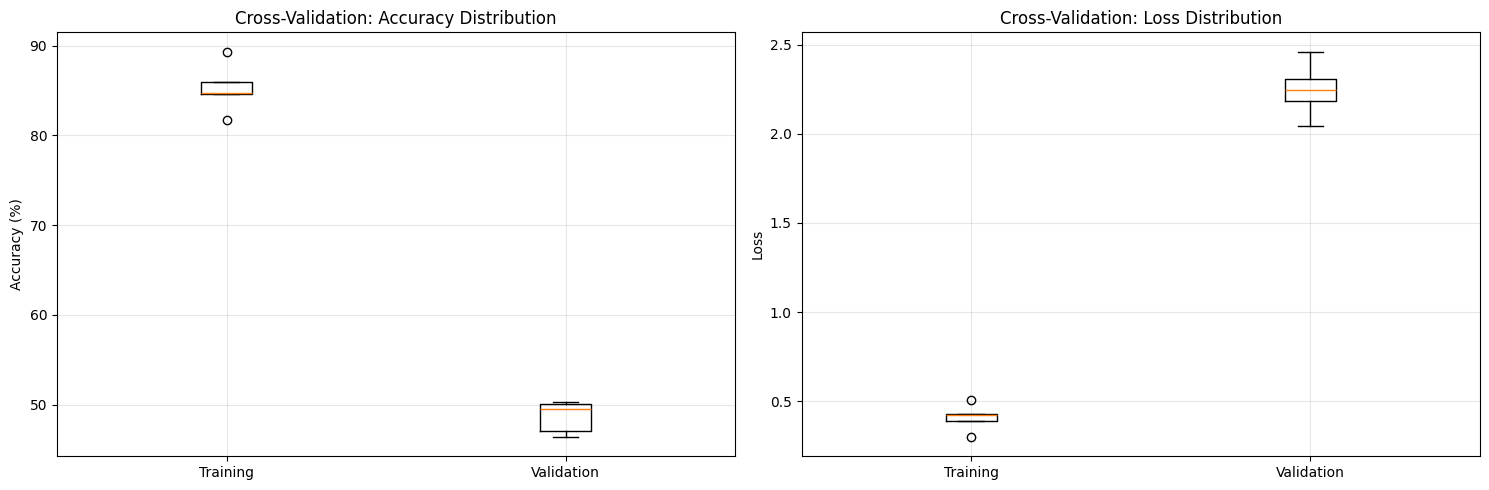

In [ ]:
# Cross-Validation Ergebnisse laden und anzeigen
print("=== Cross-Validation Ergebnisse ===")
print("Hinweis: Die Cross-Validation wurde im training.ipynb durchgeführt.")
print("Hier werden die gespeicherten Ergebnisse geladen und angezeigt.\n")

# Cross-Validation Ergebnisse aus JSON laden
results_dir = "results"
cv_results_file = os.path.join(results_dir, "cross_validation_results.json")

if os.path.exists(cv_results_file):
    with open(cv_results_file, 'r') as f:
        cv_data = json.load(f)
    
# Beste Hyperparameter aus CV-Ergebnissen
    best_lr = cv_data['best_hyperparameters']['learning_rate']
    best_batch = cv_data['best_hyperparameters']['batch_size']
    cv_results = cv_data['cv_results']
    
    print(f"Beste Hyperparameter (aus Cross-Validation): LR={best_lr}, Batch={best_batch}")
    print(f"Anzahl Epochen pro Fold: {cv_data.get('num_epochs', 'N/A')}")
    print(f"Hinweis: {cv_data.get('note', 'N/A')}")
    
    print(f"\n=== Cross-Validation Ergebnisse (Mittelwert ± Standardabweichung) ===")
    print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
    print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
    print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
    print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")
    
# F1-Scores ausgeben falls vorhanden
    if 'train_f1s' in cv_results:
        print(f"Training F1-Score: {cv_results['train_f1s']['mean']:.4f} ± {cv_results['train_f1s']['std']:.4f}")
        print(f"Validation F1-Score: {cv_results['val_f1s']['mean']:.4f} ± {cv_results['val_f1s']['std']:.4f}")
    
# Visualisierung der CV-Ergebnisse
    fig = plot_cross_validation_results(
        cv_results=cv_results
    )
    plt.show()
    
    print(f"\nErgebnisse geladen von: {cv_results_file}")
else:
    print(f"Cross-Validation-Ergebnisse nicht gefunden: {cv_results_file}")
    print("Bitte führen Sie zuerst die Cross-Validation in 'training.ipynb' durch.")

***Auswertung:*** Die Cross-Validation wurde auf der besten Hyperparameter-Konfiguration (LR=0.1, Batch=64) durchgeführt und liefert wichtige statistische Erkenntnisse über die Modellperformance:

**Training vs. Validation Performance:**
- Training Accuracy: 85.25% ± 2.47%: Das Modell erreicht eine sehr hohe Accuracy auf den Trainingsdaten
- Validation Accuracy: 48.67% ± 1.62%: Deutlich niedrigere Performance auf ungesehenen Daten
- Performance Gap: 36.58%: Dieser große Unterschied bestätigt starkes Overfitting

**Loss-Analyse:**
- Training Loss: 0.41 ± 0.07: Sehr niedriger Loss auf Trainingsdaten
- Validation Loss: 2.25 ± 0.14: Deutlich höherer Loss auf Validierungsdaten
- Loss Ratio: ~5.5x: Der Validierungs-Loss ist mehr als 5-mal höher als der Training-Loss

**Statistische Robustheit:**
- Niedrige Standardabweichungen (1.62% für Validation Accuracy, 0.14 für Validation Loss) zeigen konsistente Performance über alle 5 Cross-Validation Folds
- Die engen Konfidenzintervalle bestätigen, dass die Ergebnisse statistisch zuverlässig sind
- Die geringe Varianz deutet darauf hin, dass die Hyperparameter-Konfiguration LR=0.1, Batch=64 robust über verschiedene Datenaufteilungen funktioniert

Obwohl die Cross-Validation bestätigt, dass LR=0.1 mit Batch=64 die beste verfügbare Konfiguration ist, zeigt das deutliche Overfitting (36.58% Performance-Gap), dass das Basismodell seine Grenzen erreicht hat. Die hohe Training Accuracy (85.25%) bei gleichzeitig niedriger Validation Accuracy (48.67%) unterstreicht die Notwendigkeit für erweiterte Regularisierungstechniken oder komplexere Modellarchitekturen, um die Generalisierungsfähigkeit zu verbessern.

### Hyperparameter-Experimente:

**Wo werden die Experimente durchgeführt:** Die Experimente werden im separaten Notebook `hyperparameter_experiments.ipynb` durchgeführt. Hier in `main.ipynb` werden die Ergebnisse geladen, analysiert und interpretiert.

**Zielsetzung:**
Systematische Untersuchung des Einflusses der Modellkomplexität auf die Performance durch Variation von:
1. **Modelltiefe** (Anzahl Conv-Layer)
2. **Modellbreite** (Anzahl Filter pro Layer)
3. **FC-Layer Breite** (Anzahl Neuronen in FC-Layer)

**Vorgehen:**
Für jede Hypothese wird systematisch vorgegangen:
- **a) Hypothese:** Theoretische Erwartung und Begründung mit Literaturreferenzen
- **b) Experiment:** Durchführung der Experimente mit verschiedenen Konfigurationen
- **c) Analyse/Reflexion:** Vergleich der Ergebnisse, Überprüfung der Hypothesen und Reflexion

**Methodik:**
- Alle Experimente verwenden die gleichen Trainings-/Validierungs-/Test-Splits (Seed=42)
- Konsistente Hyperparameter: LR=0.01, Batch=64, 60 Epochen, SGD ohne Momentum
- Nur der zu testende Hyperparameter wird variiert
- Alle Ergebnisse werden in `results/` gespeichert und in `plots/experiments/` visualisiert

#### Kategorie 1 - Modellkomplexität

##### Hypothese 1: Modelltiefe (Anzahl Conv-Layer)

**a) Hypothese:**
Mehr Conv-Layer erhöhen die Modellkapazität und können komplexere Features lernen, was die Performance verbessert. Zu viele Layer können jedoch zu Overfitting führen und das Training erschweren (Vanishing Gradient Problem).

**Begründung:** 
Tiefere Netzwerke können hierarchische Features lernen. Wie Fleuret (2023, S. 46-47) beschreibt, können CNNs in frühen Layern einfache Merkmale wie Kanten extrahieren, während tiefere Layer zunehmend komplexere Muster erkennen. Diese hierarchische Repräsentation ermöglicht es tiefen Modellen, mit einem festen Rechenbudget komplexere Funktionen zu lernen. 

Allerdings warnt Fleuret (2023, S. 43-44) auch vor dem **Vanishing Gradient Problem**: Wenn der Gradient rückwärts durch viele Layer propagiert wird, kann er exponentiell abnehmen, was das Training sehr tiefer Netzwerke ohne spezielle Techniken wie Residual Connections erschwert oder unmöglich macht.

**Quelle:**
Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
4-5 Conv-Layer sollten besser sein als 3, aber >6 Layer könnten ohne Residual Connections unter Vanishing Gradient und Degradation Problemen leiden.

=== Hypothese 1: Modelltiefe (Anzahl Conv-Layer) ===

Ergebnisse geladen. Zusammenfassung:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)  Beste Epoche
     3_layers   171,271             48.87              46.46               31.64            42
     2_layers   300,231             48.26              45.75               27.31            33
     4_layers   171,399             50.70              49.56               30.50            51
     6_layers 2,752,647             49.13              47.02               40.57            48

Beste Konfiguration: 4_layers
  Beste Val Acc: 50.70%
  Parameter: 171,399

hyp1_depth_comparison.png:


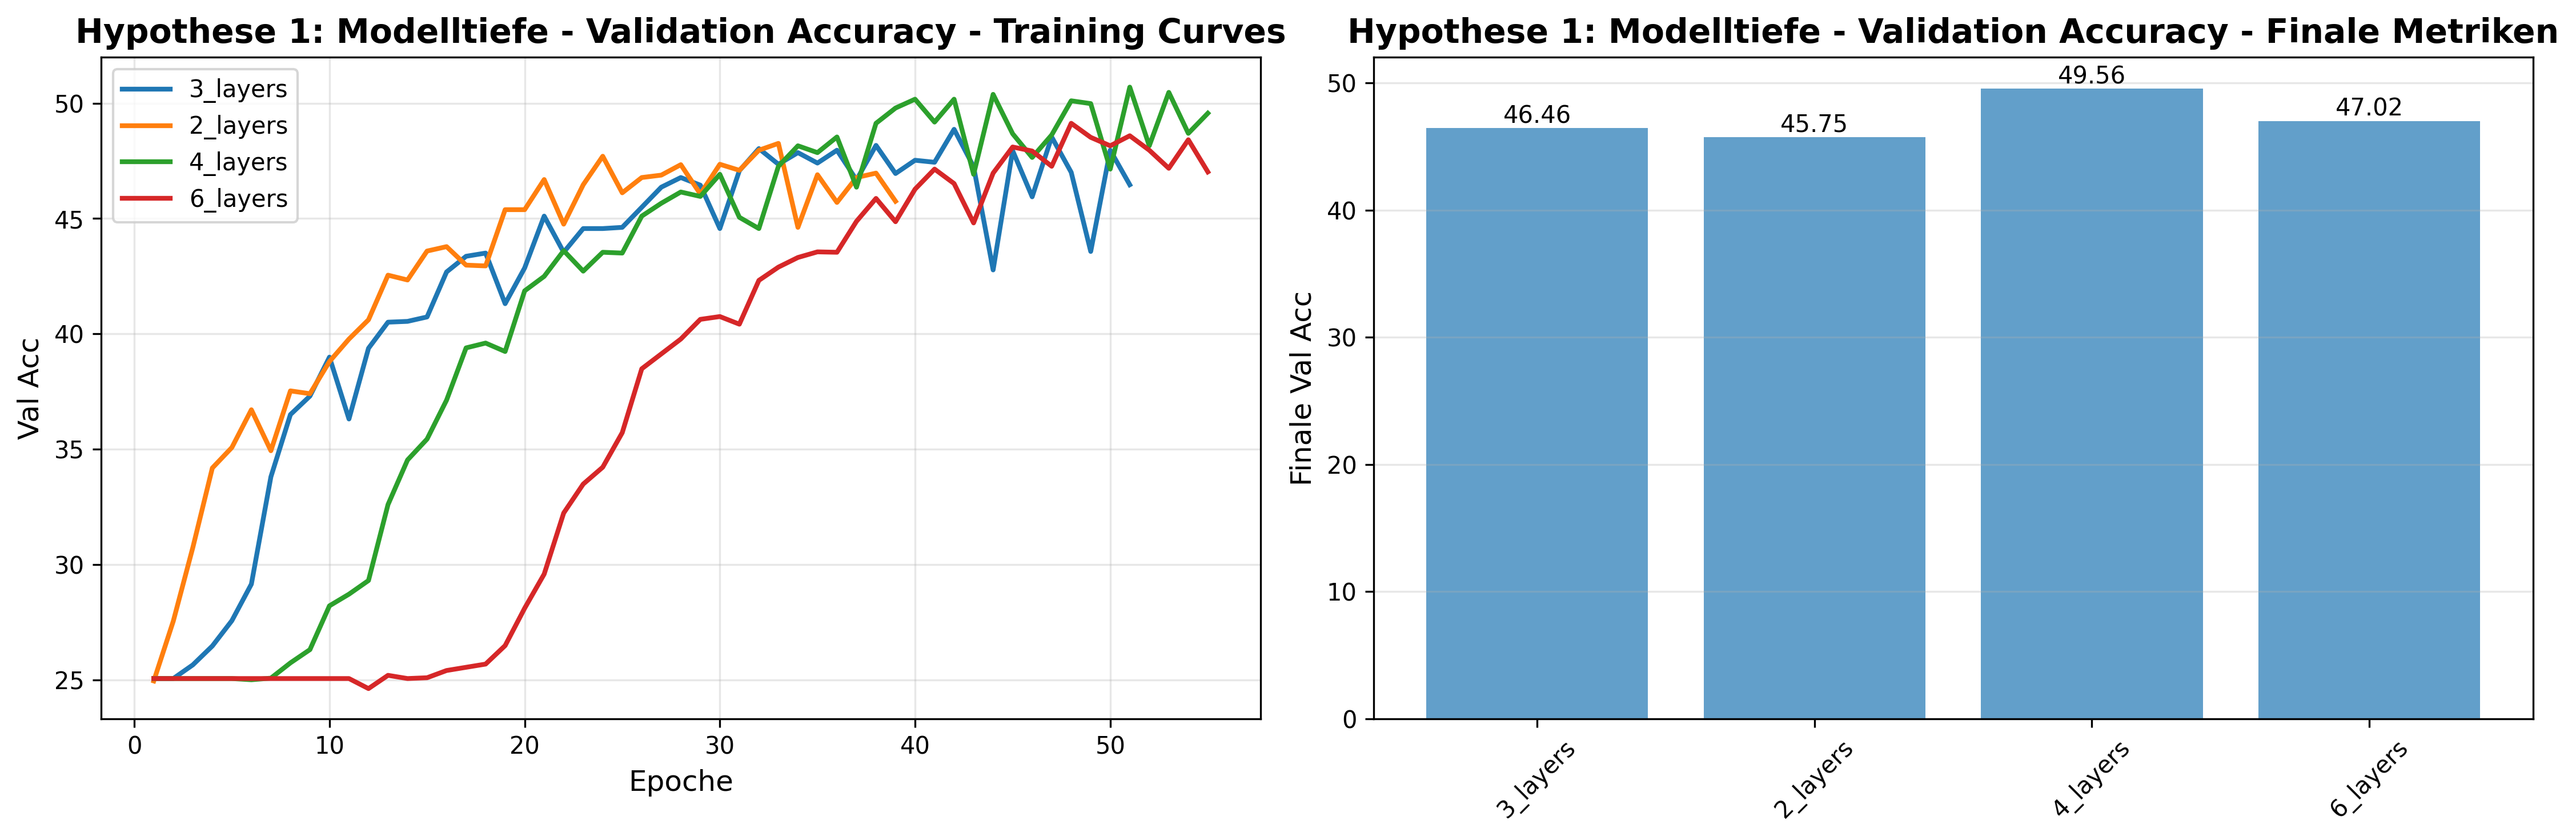


hyp1_complexity_analysis.png:


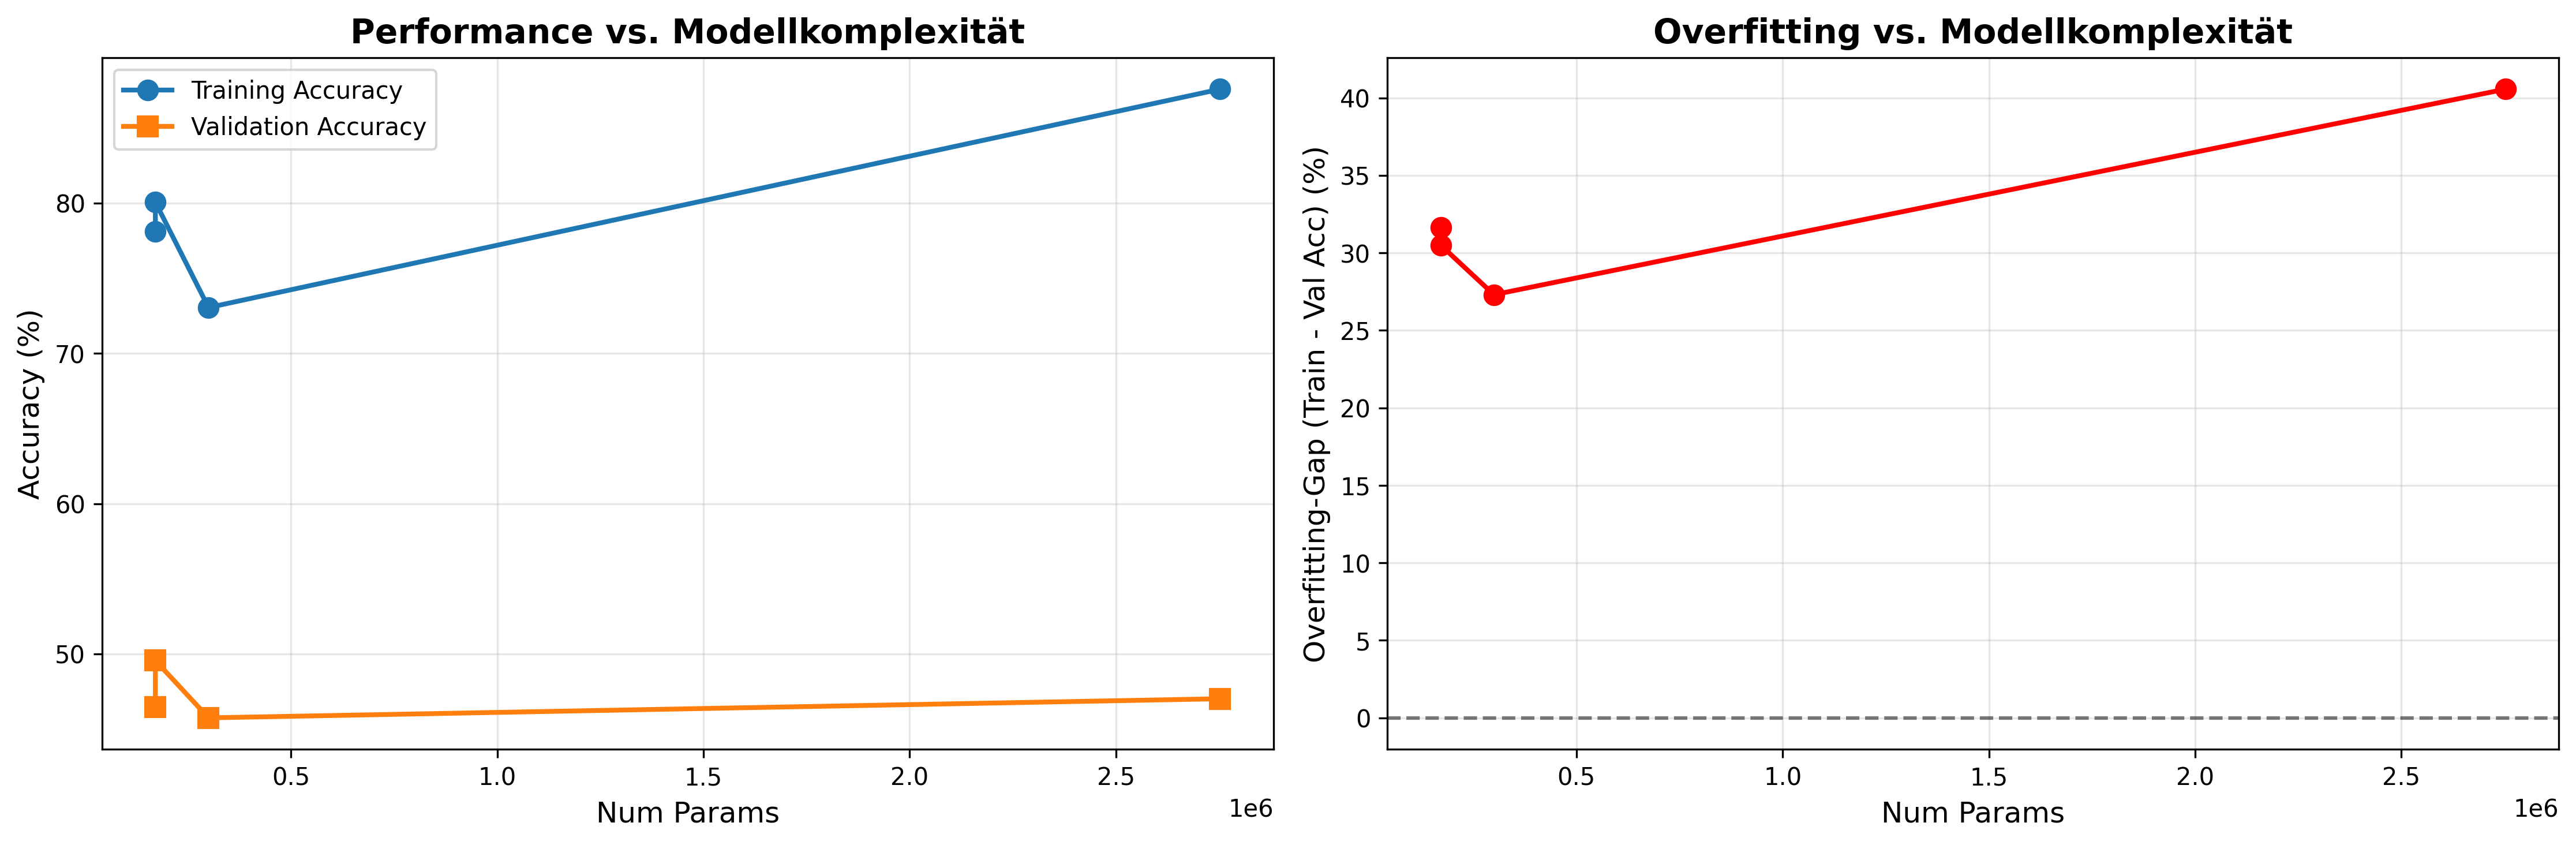


hyp1_training_curves.png:


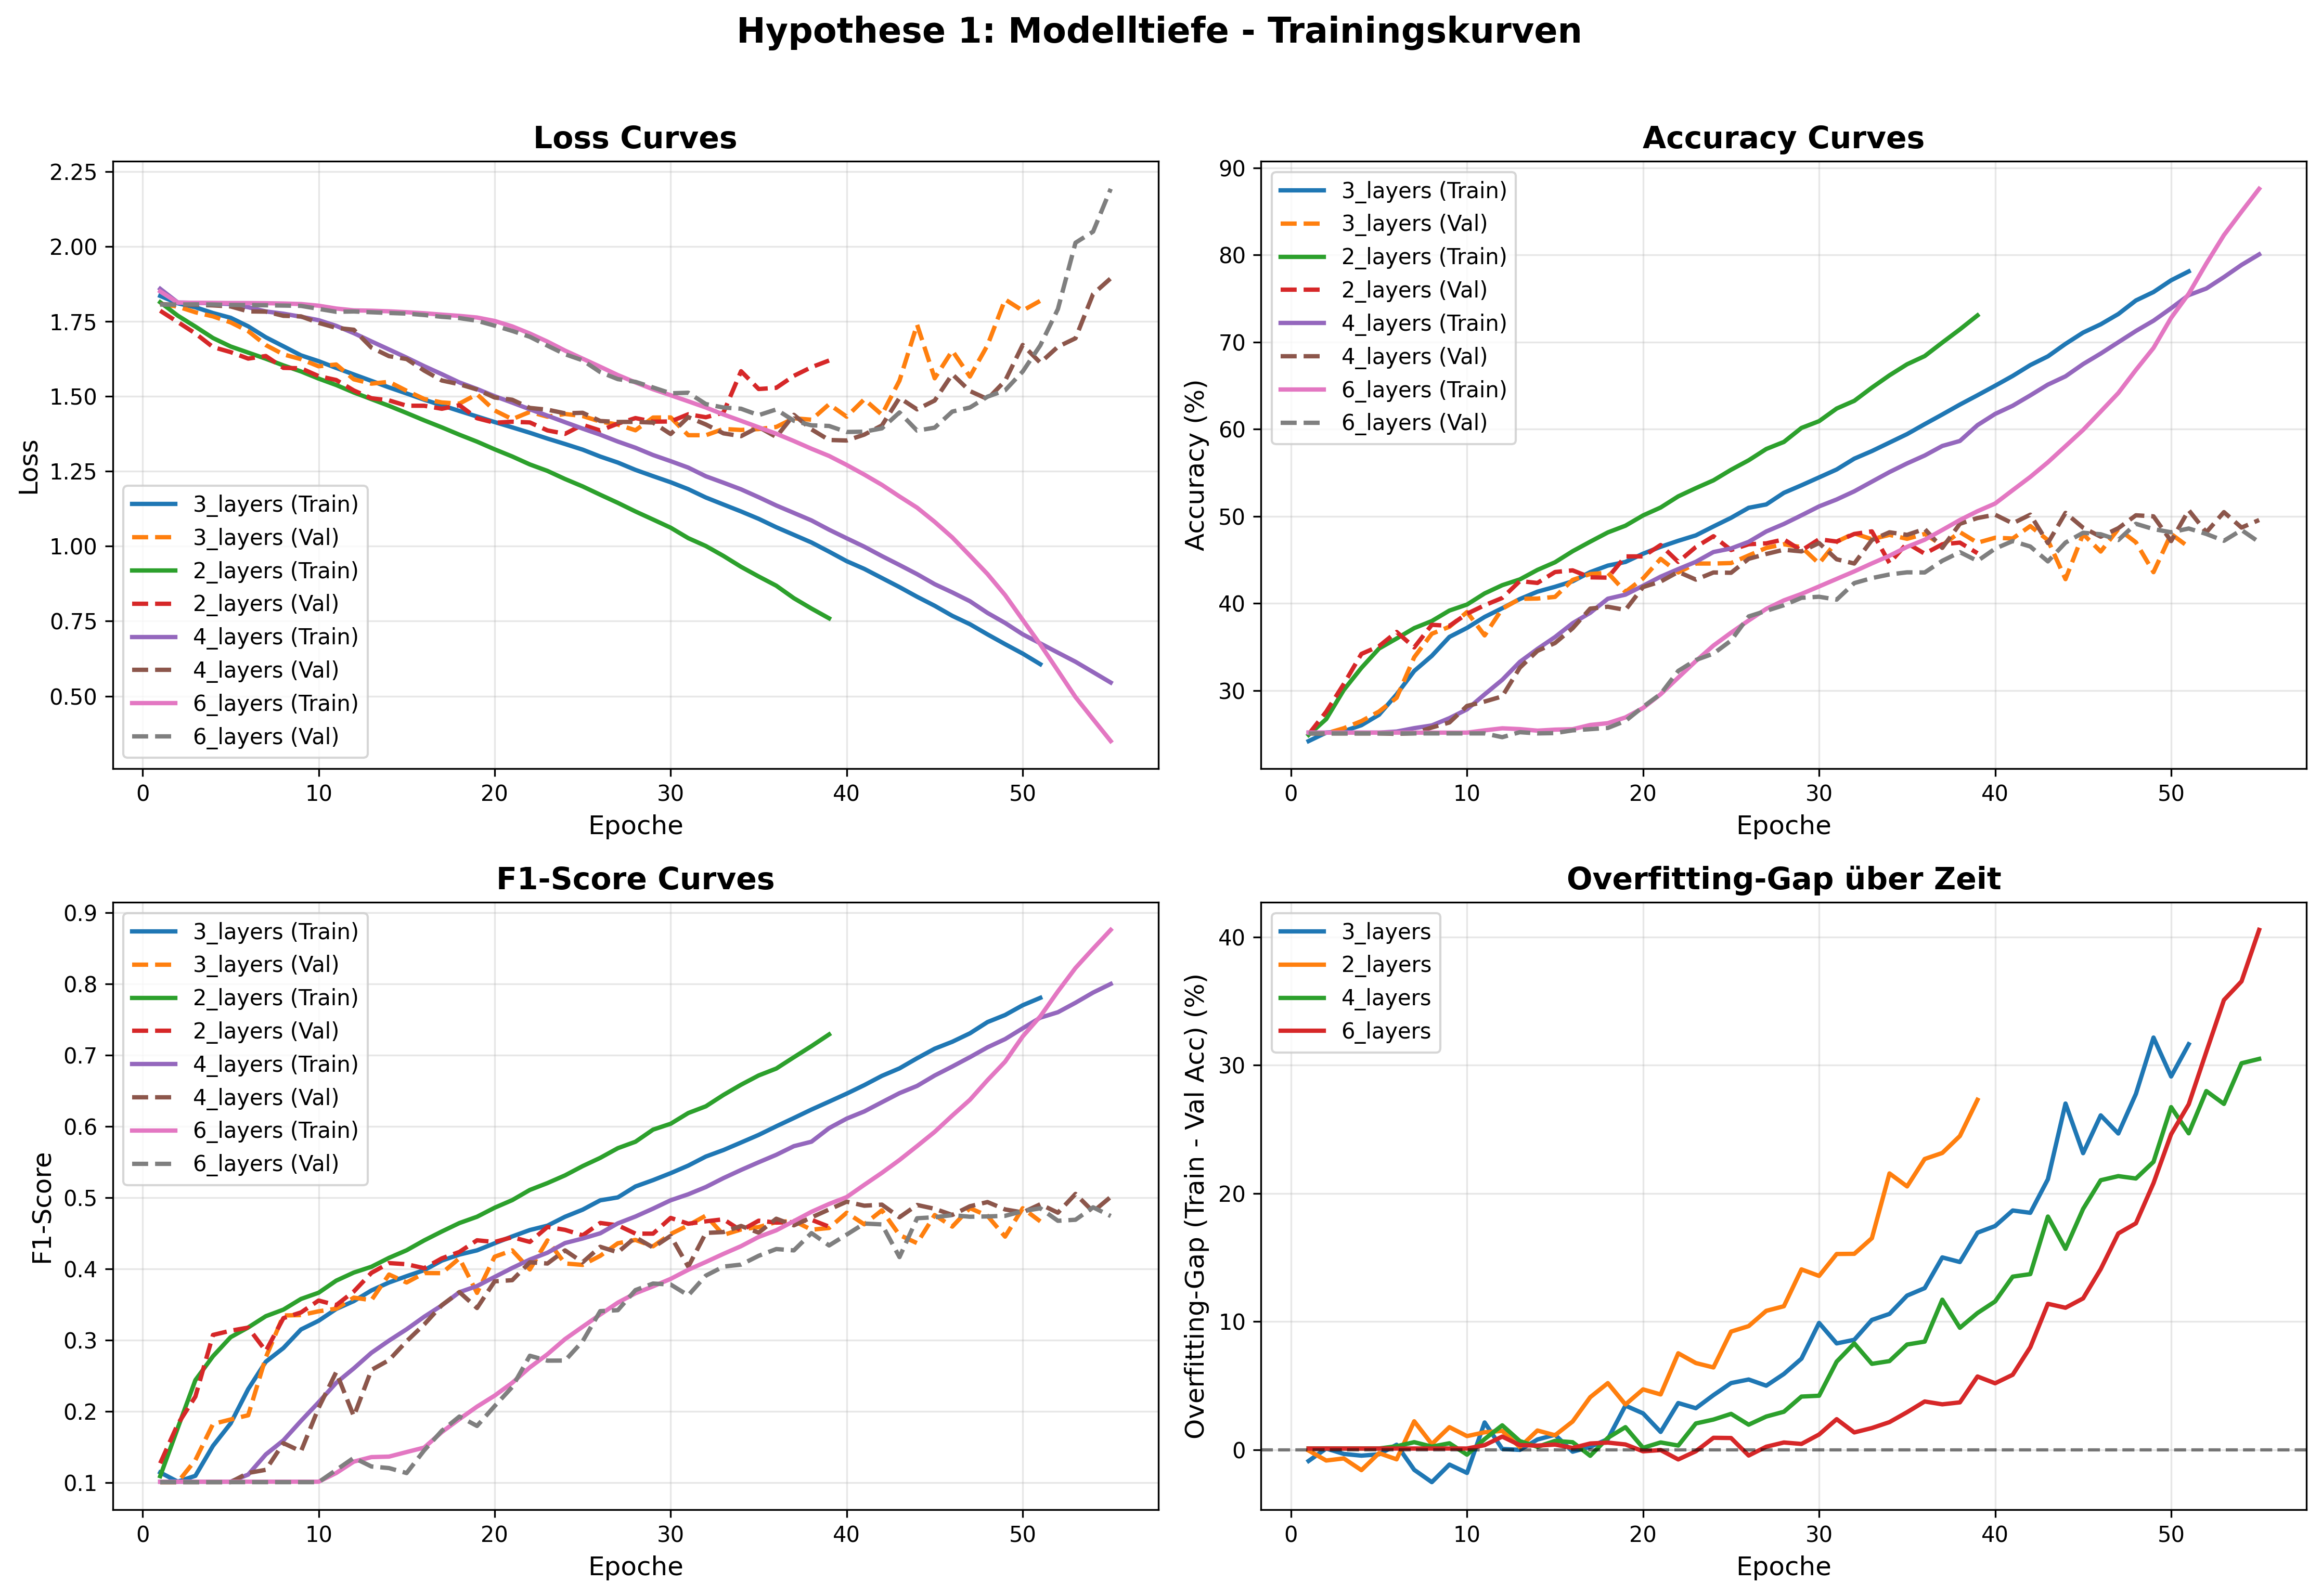

In [ ]:
# Hypothese 1 Ergebnisse laden und analysieren
print("=== Hypothese 1: Modelltiefe (Anzahl Conv-Layer) ===")

# Ergebnisse aus JSON laden
results_dir = "results"
hyp1_file = os.path.join(results_dir, "hypothesis_1_depth.json")

if os.path.exists(hyp1_file):
    with open(hyp1_file, 'r') as f:
        hyp1_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
# Zusammenfassungstabelle (Metriken: siehe „Überblick der Metriken“)
    summary_data = []
    for name, result in hyp1_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}",
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
# Beste Konfiguration
        best_config = max(hyp1_results.items(), 
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
# Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp1_depth_comparison.png",
        "plots/experiments/hyp1_complexity_analysis.png",
        "plots/experiments/hyp1_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
        else:
            print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {hyp1_file}")
    print("Bitte führen Sie zuerst die Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Auswertung Hypothese 1:***

Die Auswertung verwendet die im Abschnitt **„Überblick der Metriken“** definierten Größen: Accuracy, F1-Score (weighted), Loss sowie Overfitting-Gap (Acc und F1).

- **Bestätigung der Hypothese:** Die Erwartung wird **teilweise bestätigt**. 4 Conv-Layer erreichen die **beste Validation Accuracy** (ca. 50,7 %) und übertreffen die Baseline (3 Layer, ca. 48,9 %). 6 Layer zeigen den **größten Overfitting-Gap** (ca. 40,6 % Acc-Gap) – sehr tiefe Netze ohne Residual Connections führen zu stärkerem Overfitting. 2 Layer haben den **kleinsten Overfitting-Gap** (ca. 27,3 %), performen aber etwas schlechter (ca. 48,3 %).

- **Performance-Vergleich:** Beste Konfiguration ist **4 Layer** (beste Val Acc und Val F1). Danach folgen 6 Layer, 3 Layer (Baseline) und 2 Layer.

- **Overfitting-Analyse:** Der Overfitting-Gap (Train−Val Acc) steigt mit der Tiefe: 2L < 4L < 3L < 6L. 6 Layer overfitten am stärksten, 2 Layer generalisieren am besten.

- **Parameter-Effizienz:** 4 Layer haben nur unwesentlich mehr Parameter als 3 Layer, liefern aber klar bessere Val-Performance. 6 Layer haben deutlich mehr Parameter (ca. 2,75 Mio.) ohne bessere Generalisierung.

- **Training-Stabilität:** Alle Varianten konvergieren; Early Stopping beendet das Training stabil.

- **Reflexion:** Moderate zusätzliche Tiefe (4 Layer) nützt; zu viel Tiefe (6 Layer) verschlechtert die Generalisierung. Für weitere Verbesserungen wären Regularisierung (Dropout, BatchNorm) oder Residual Connections sinnvoll.

##### Hypothese 2: Modellbreite (Anzahl Filter pro Layer)

**a) Hypothese:**
Mehr Filter pro Layer erhöhen die Kapazität und können mehr Features gleichzeitig lernen. Dies verbessert die Performance, erhöht aber auch die Parameteranzahl und das Overfitting-Risiko.

**Begründung:** 
Mehr Filter ermöglichen reichere lokale Repräsentationen durch mehr Feature-Maps pro Layer. Wie Fleuret (2023, S. 69) erklärt, werden Convolutions verwendet, um Information zu rekombinieren und "die räumliche Größe der Repräsentation zu reduzieren im Austausch für eine größere Anzahl von Kanälen, was sich in eine reichere lokale Repräsentation übersetzt."

Die Anzahl der Filter (Kanäle) bestimmt direkt die Ausdruckskraft des Netzwerks: Jeder Filter kann unterschiedliche Muster oder Features detektieren (z.B. verschiedene Kantenrichtungen, Texturen oder komplexere Strukturen). Allerdings wächst die Parameteranzahl einer Convolutional Layer quadratisch mit der Anzahl der Kanäle (Fleuret 2023, S. 62), was sowohl die Rechenkosten erhöht als auch das Risiko von Overfitting steigert.

Ein klassisches Architekturmuster ist es, die Anzahl der Kanäle schrittweise zu erhöhen, während die räumliche Auflösung abnimmt (siehe ResNet-Architektur in Fleuret 2023, S. 104-106), um ein Gleichgewicht zwischen räumlicher Information und Feature-Reichhaltigkeit zu schaffen.

**Quelle:**
Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
[32, 64, 128] Filter sollten besser sein als [16, 32, 64], aber mit höherem Overfitting-Risiko bei begrenzten Trainingsdaten. [64, 128, 256] könnte zu stark overfitting zeigen.

**b) Experiment:**

**Baseline:** [16, 32, 64] Filter  
**Varianten:** [8, 16, 32], [32, 64, 128], [64, 128, 256]  
**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer

**c) Analyse:**

- Performance vs. Parameteranzahl (Trade-off visualisieren)
- Overfitting-Verhalten (Train-Val Gap analysieren)
- Trade-off zwischen Kapazität und Generalisierung
- Konvergenzgeschwindigkeit bei verschiedenen Breiten

=== Hypothese 2: Modellbreite (Anzahl Filter pro Layer) ===

Ergebnisse geladen. Zusammenfassung:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
     3_layers   171,271             48.87              46.46               31.64
      8_16_32    80,135             50.66              48.55               23.24
    32_64_128   388,103             51.22              49.90               31.07
   64_128_256   960,007             52.46              50.73               31.16

hyp2_width_comparison.png:


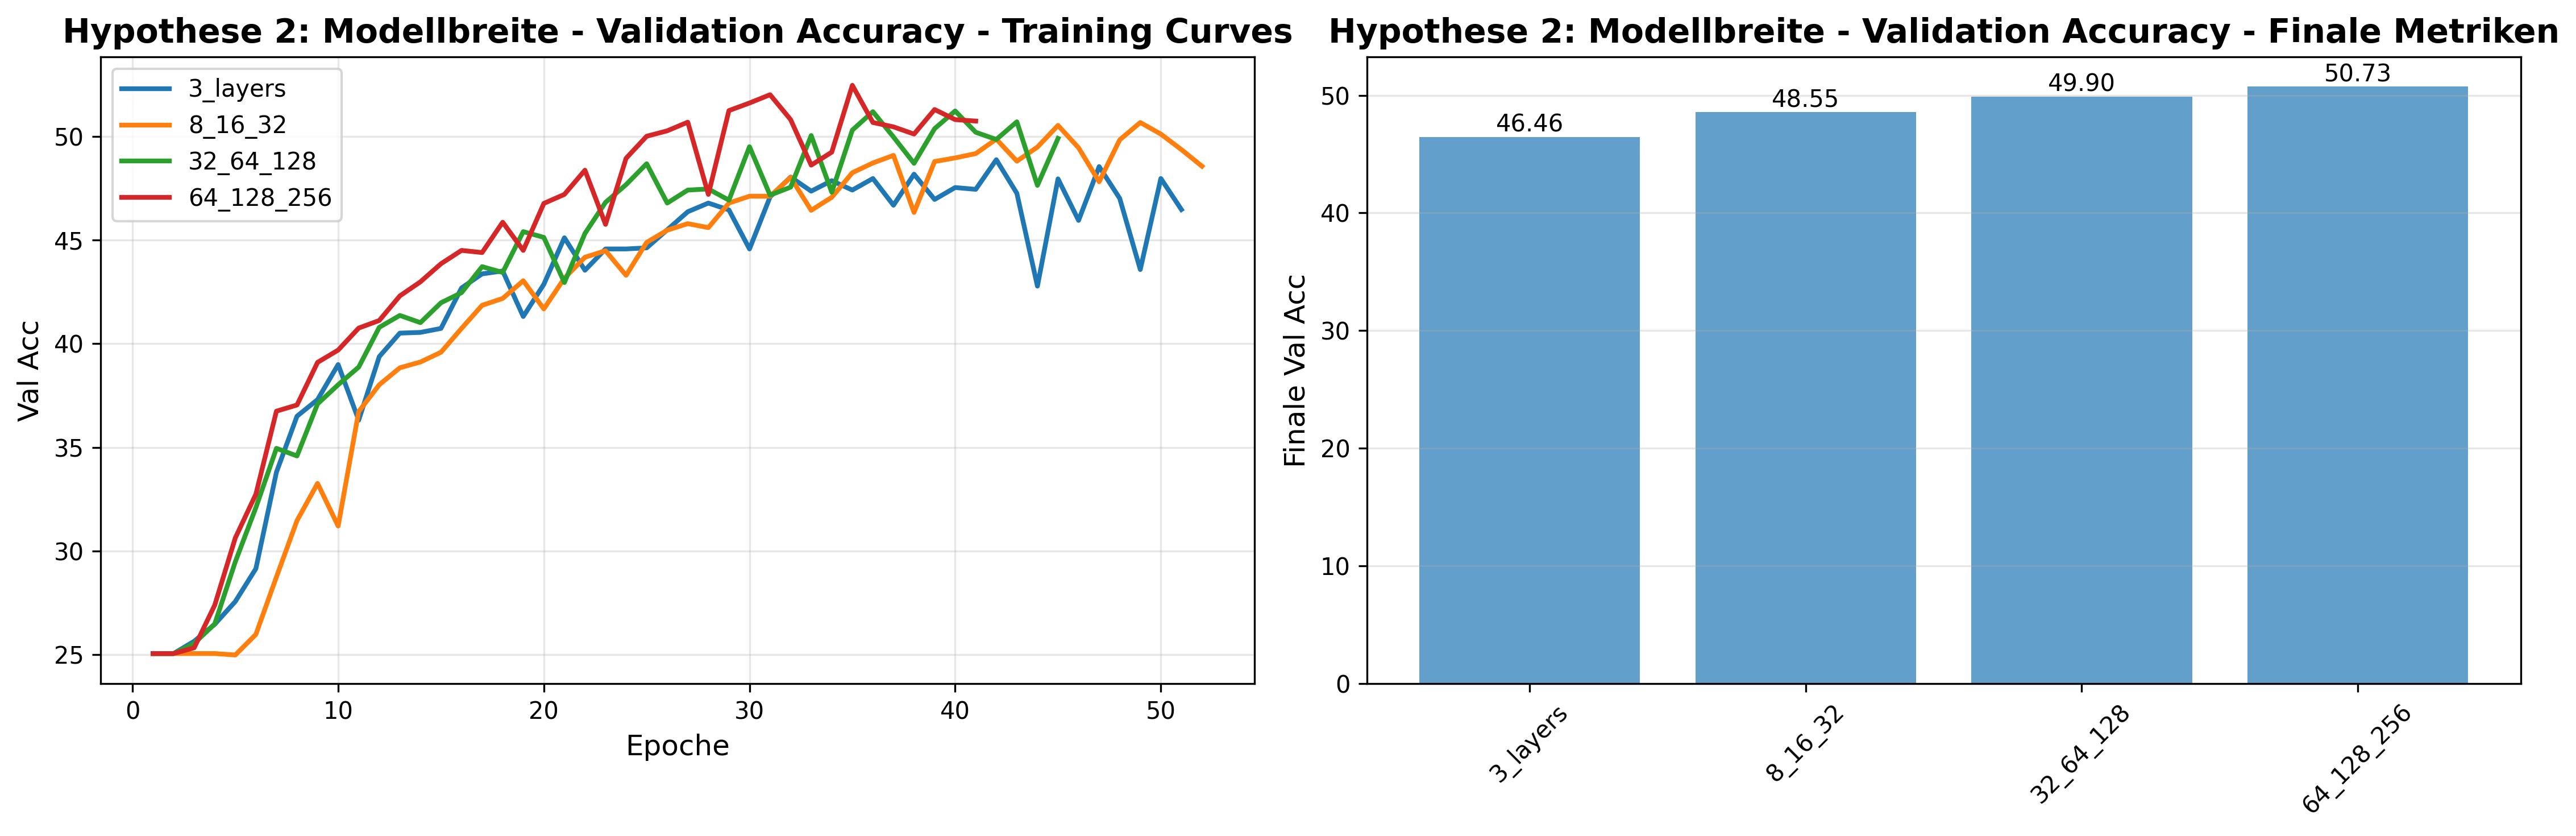


hyp2_complexity_analysis.png:


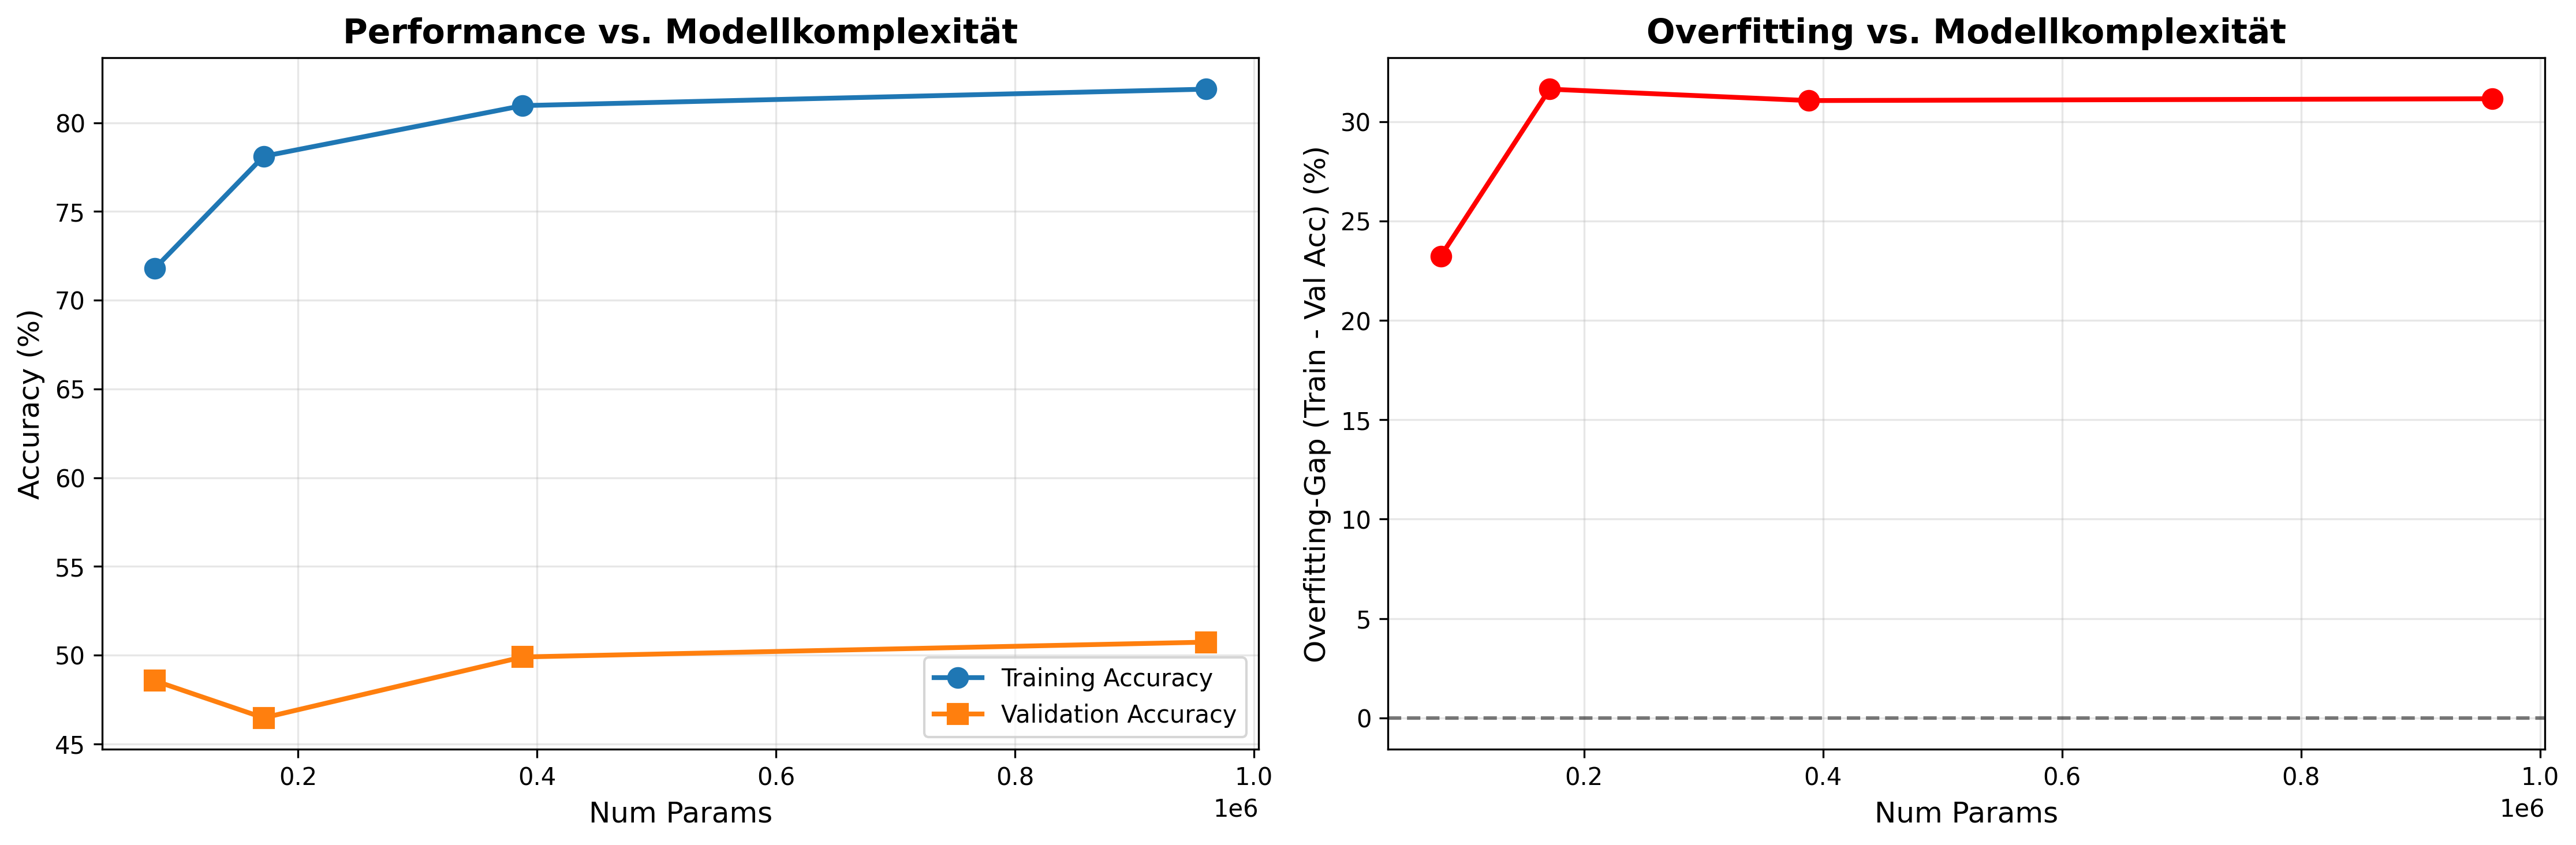


hyp2_training_curves.png:


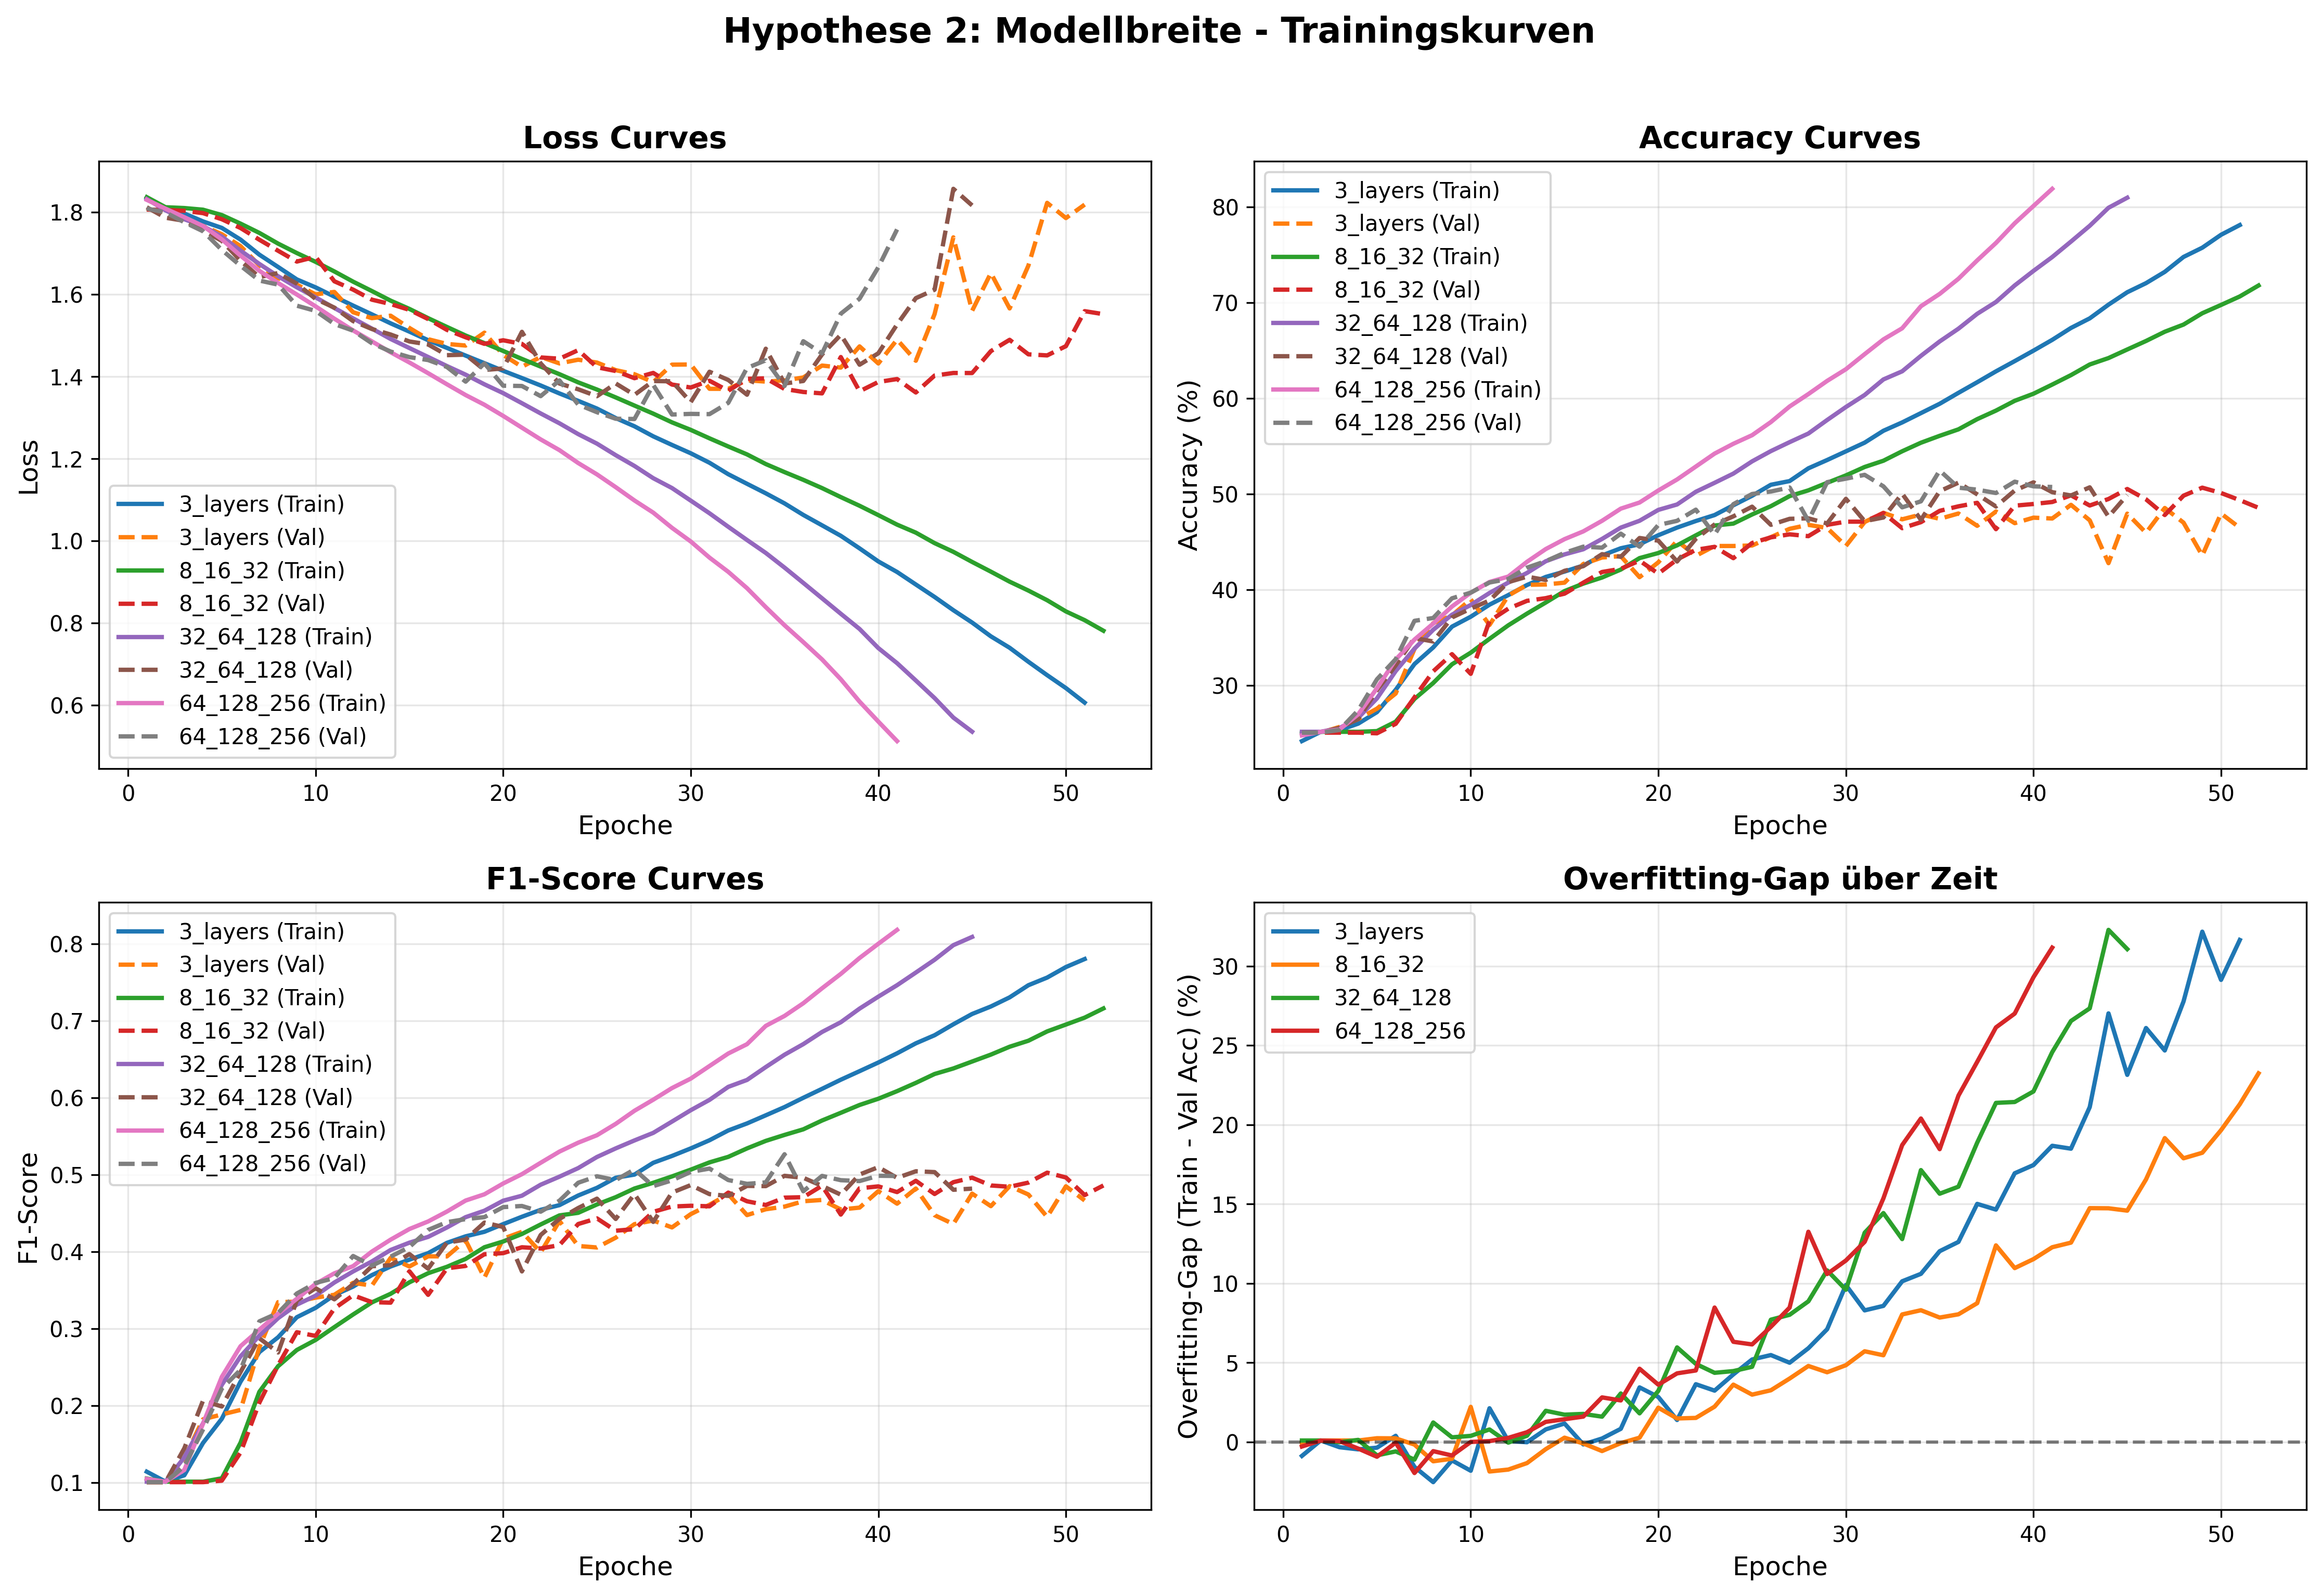

In [ ]:
# Hypothese 2 Ergebnisse laden und analysieren
print("=== Hypothese 2: Modellbreite (Anzahl Filter pro Layer) ===")

hyp2_file = os.path.join(results_dir, "hypothesis_2_width.json")

if os.path.exists(hyp2_file):
    with open(hyp2_file, 'r') as f:
        hyp2_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
# Zusammenfassungstabelle (Metriken: siehe „Überblick der Metriken“)
    summary_data = []
    for name, result in hyp2_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}",
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        best_config = max(hyp2_results.items(),
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Overfitting-Gap Acc: {best_config[1].get('overfitting_gap_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
# Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp2_width_comparison.png",
        "plots/experiments/hyp2_complexity_analysis.png",
        "plots/experiments/hyp2_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
else:
    print(f"Ergebnisse nicht gefunden: {hyp2_file}")
    print("Bitte führen Sie zuerst die Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Auswertung Hypothese 2:***

Es gelten dieselben **Metriken** wie oben (Accuracy, F1-Score weighted, Loss, Overfitting-Gap Acc/F1).

- **Bestätigung der Hypothese:** Die Erwartung wird **bestätigt**. Mehr Filter ([32,64,128] und [64,128,256]) verbessern die **Validation Accuracy** gegenüber der Baseline [16,32,64]; beste Val Acc bei [64,128,256] (ca. 52,5 %). [8,16,32] hat den **kleinsten Overfitting-Gap** (ca. 23,2 %) bei guter Val Acc (ca. 50,7 %).

- **Performance vs. Parameteranzahl:** Höhere Filteranzahl geht mit mehr Parametern und besserer Val Performance einher; [64,128,256] hat die meisten Parameter und die beste Val Acc. Der Trade-off zwischen Kapazität und Generalisierung zeigt sich im Overfitting-Gap.

- **Overfitting-Verhalten:** [8,16,32] generalisiert am besten (kleinster Gap). [32,64,128] und [64,128,256] haben größere Gaps – mehr Kapazität führt ohne zusätzliche Regularisierung zu stärkerem Overfitting.

- **Reflexion:** Mehr Modellbreite kann die Performance steigern, aber bei begrenzten Daten verstärkt sich das Overfitting. Eine Kombination mit Dropout oder Data Augmentation wäre für die breiteren Varianten empfehlenswert.

##### Hypothese 3: FC-Layer Breite (Anzahl Neuronen)

**a) Hypothese:**
Mehr Neuronen in den FC-Layern können komplexere Entscheidungsgrenzen lernen, aber zu viele Neuronen führen zu Overfitting.

**Begründung:** 
FC-Layer (Fully Connected Layers) kombinieren die durch Convolutional Layers extrahierten Features für die finale Klassifikation. Wie Fleuret (2023, S. 61-62) erklärt, können FC-Layer nicht nur geometrische Transformationen durchführen, sondern auch als Matching-Mechanismus interpretiert werden: "Das Skalarprodukt kann als Ähnlichkeitsmaß interpretiert werden, sodass ein Matrix-Vektor-Produkt als Berechnung von Matching-Scores zwischen Queries (kodiert durch die Input-Vektoren) und Keys (kodiert durch die Matrix-Zeilen) verstanden werden kann."

Die Anzahl der Neuronen bestimmt die Kapazität des FC-Layers, komplexe Kombinationen der gelernten Features zu repräsentieren. Allerdings ist die Parameteranzahl eines FC-Layers proportional zum Produkt der Input- und Output-Dimensionen (Fleuret 2023, S. 62), was bei großen Dimensionen zu erheblichem Overfitting-Risiko führt.

Der Universal Approximation Theorem (Fleuret 2023, S. 99-100) besagt zwar, dass bereits ein einzelnes Hidden Layer mit genügend Neuronen theoretisch jede Funktion approximieren kann, jedoch benötigt dies möglicherweise eine extrem große Anzahl von Neuronen. In der Praxis ist es effizienter, moderate Layer-Größen zu verwenden und stattdessen die Tiefe zu erhöhen.

**Quelle:**
- Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
128-256 Neuronen sollten besser sein als 64, da sie ausreichend Kapazität für komplexe Feature-Kombinationen bieten. Jedoch könnte >512 Neuronen zu starkem Overfitting führen, besonders bei begrenzten Trainingsdaten.

**b) Experiment:**

**Baseline:** 64 Neuronen in fc1  
**Varianten:** 32, 128, 256, 512 Neuronen  
**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer, [16,32,64] Filter

**c) Analyse:**

- Performance vs. FC-Layer-Größe
- Overfitting-Gap (Train-Val Differenz analysieren)
- Effizienz der FC-Layer-Dimensionierung (Performance pro Parameter)
- Vergleich mit Universal Approximation Theorem: Ist ein größerer Layer besser als mehrere kleinere?

=== Hypothese 3: FC-Layer Breite (Anzahl Neuronen) ===

Ergebnisse geladen. Zusammenfassung:
Konfiguration Parameter Beste Val Acc (%) Finale Val Acc (%) Overfitting-Gap (%)
     3_layers   171,271             48.87              46.46               31.64
     32_units    97,287             49.65              49.22               22.55
    128_units   319,239             49.86              49.53               34.97
    256_units   615,175             47.82              47.82               24.28
    512_units 1,207,047             49.34              47.68               43.86

hyp3_fc_width_comparison.png:


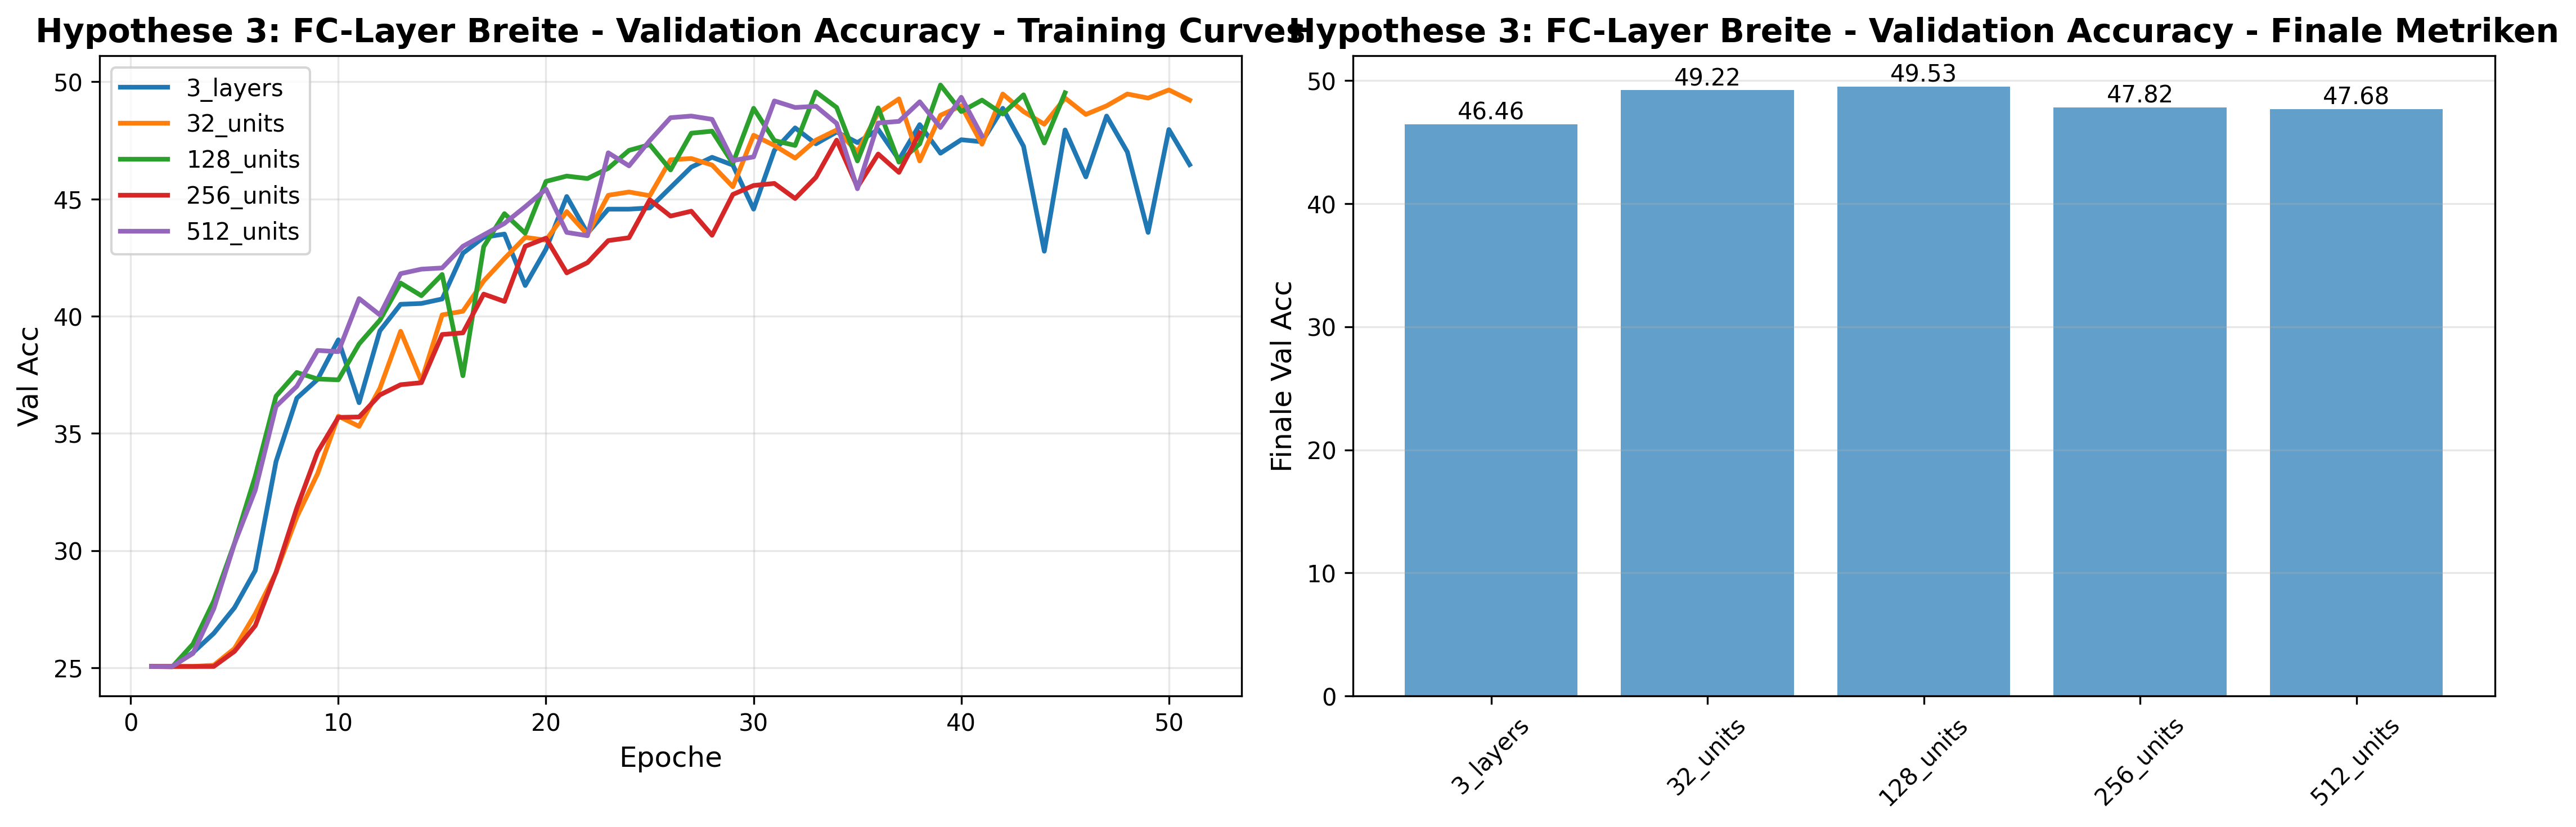


hyp3_complexity_analysis.png:


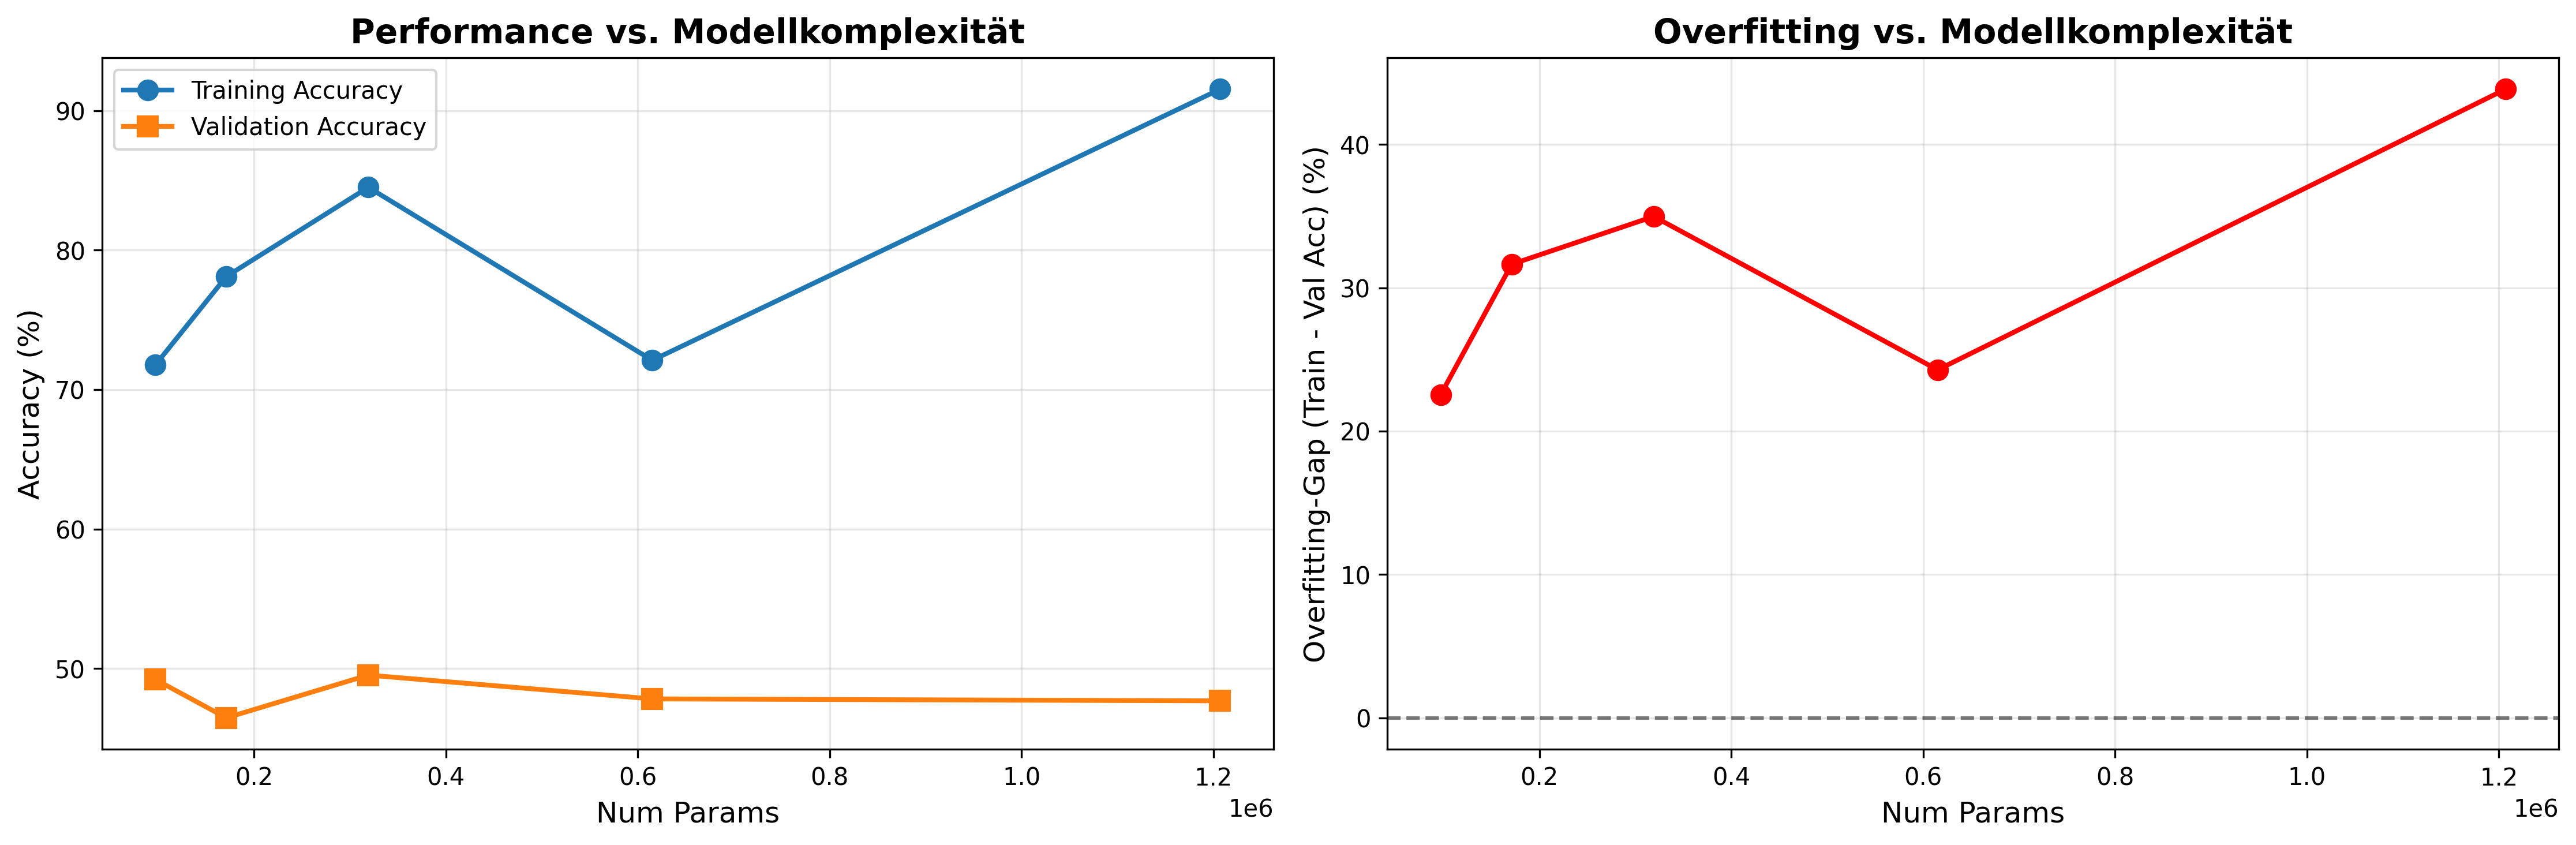


hyp3_training_curves.png:


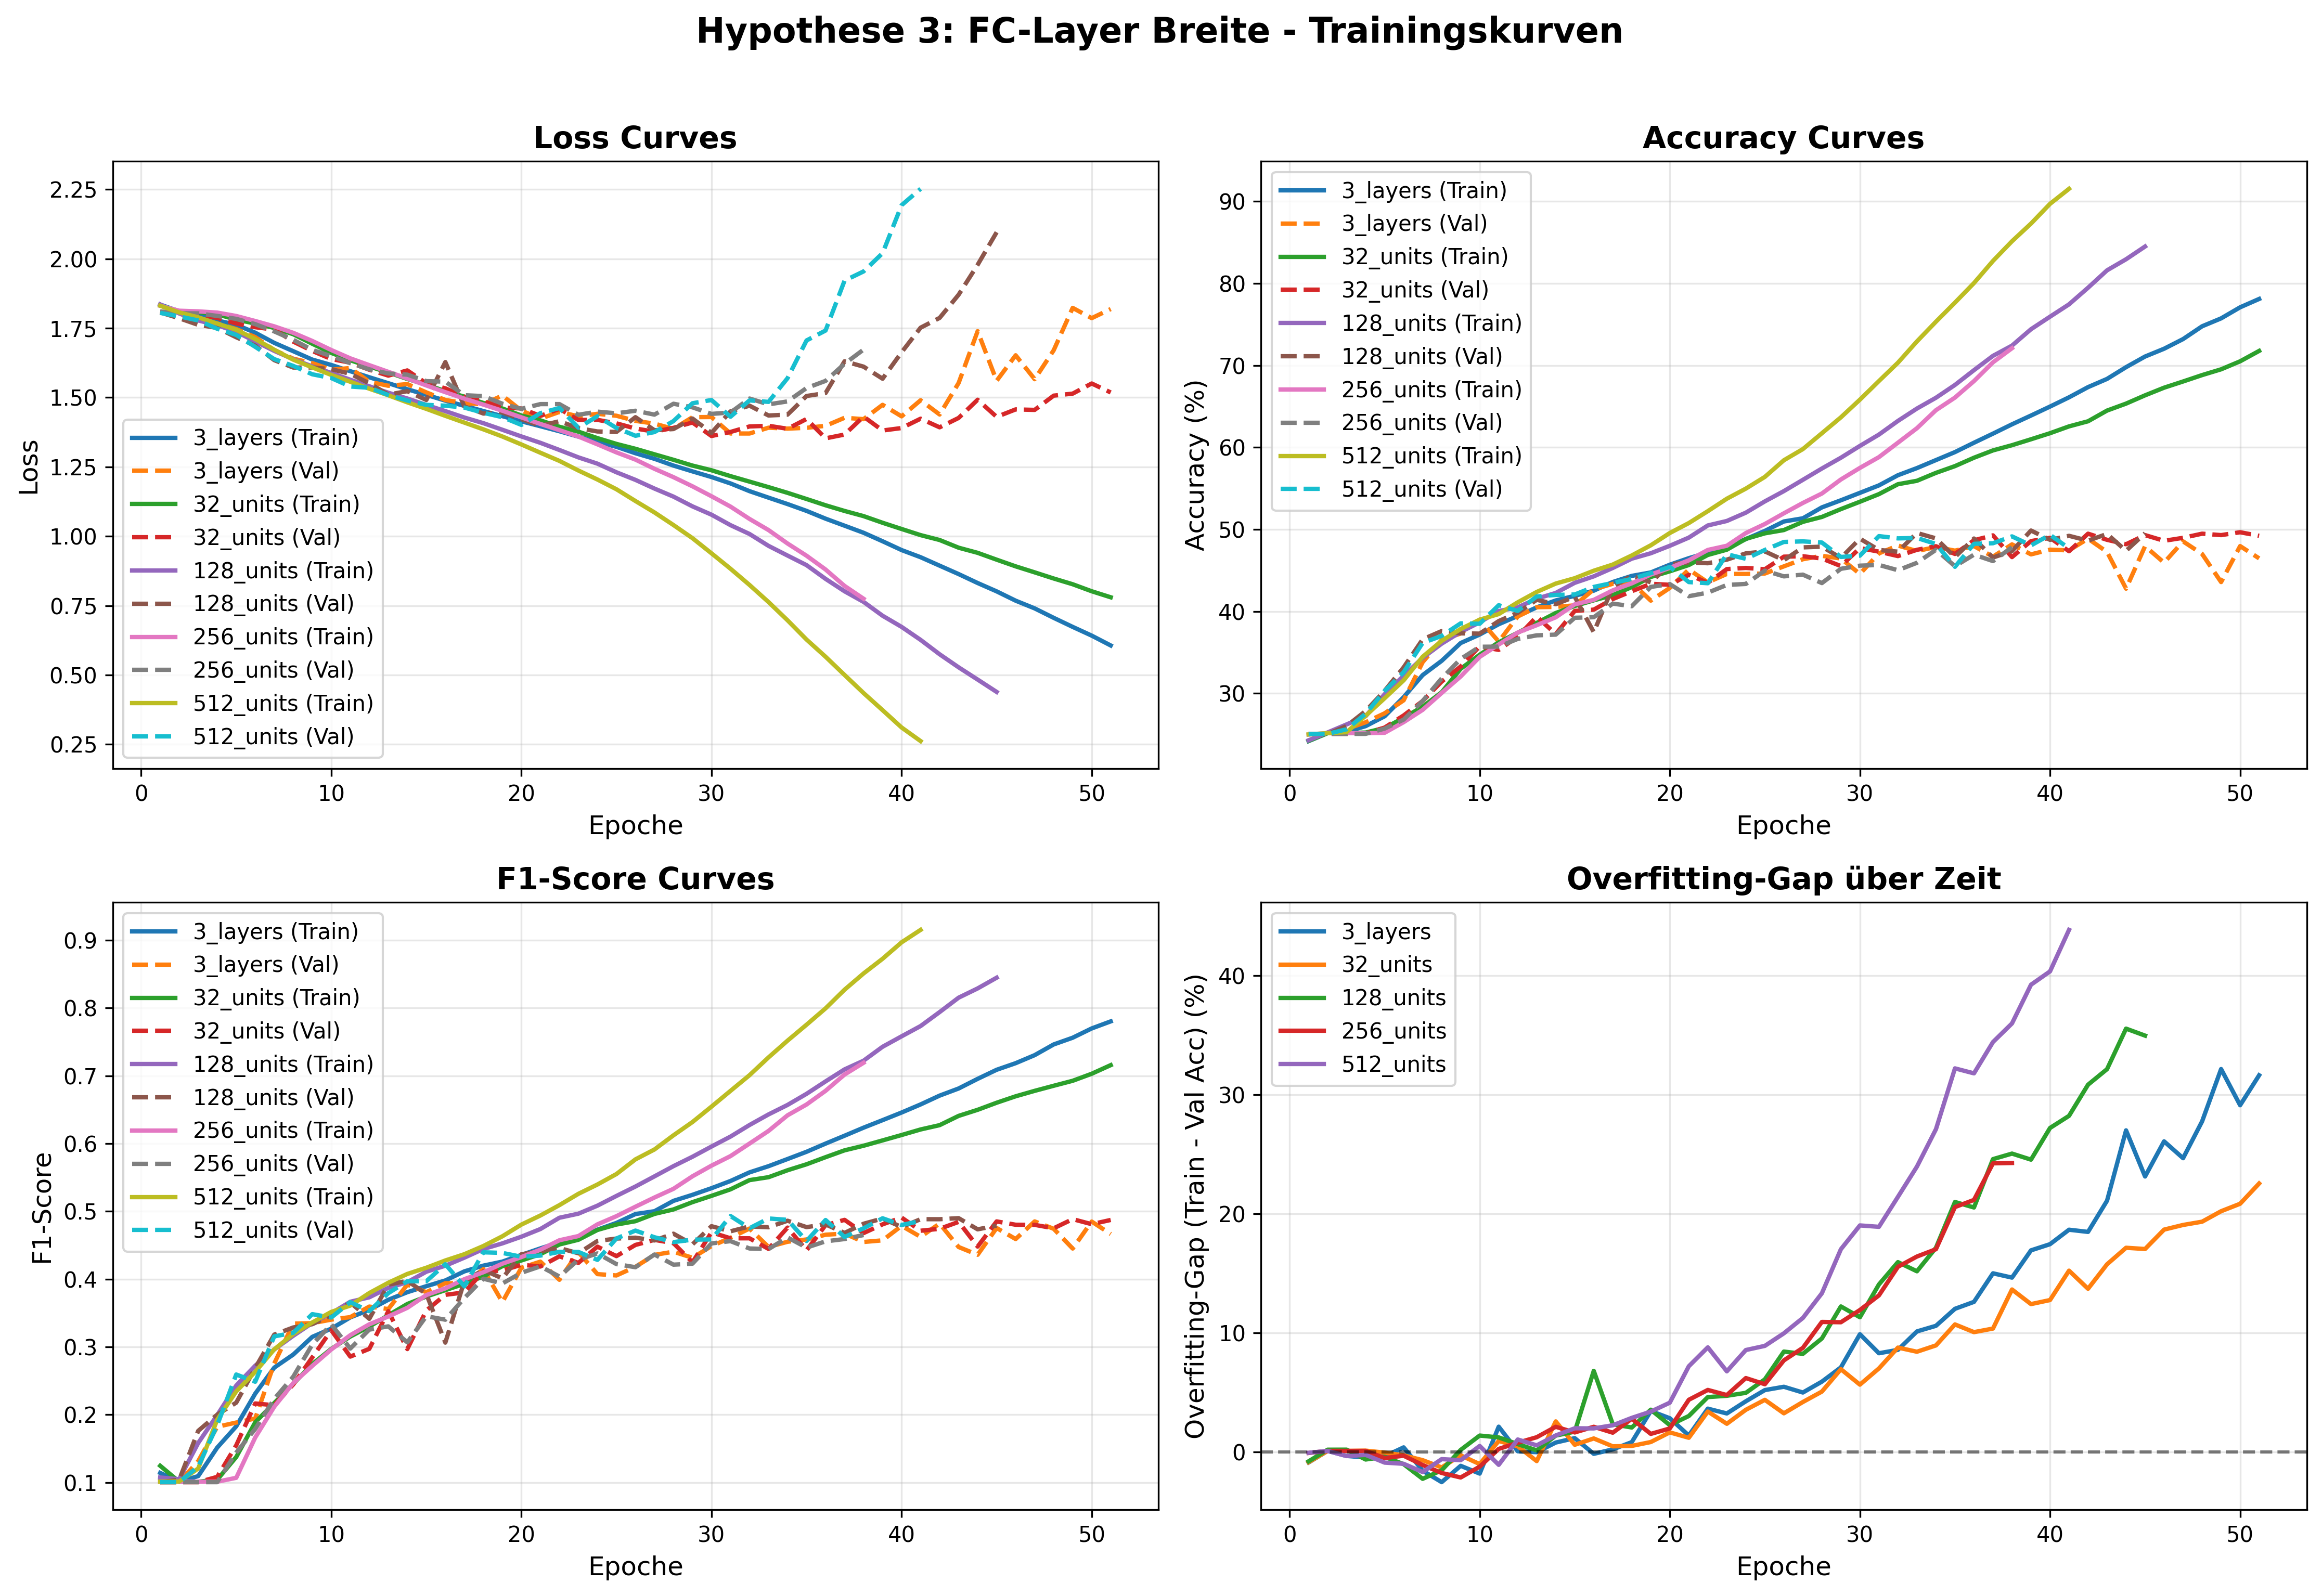

In [ ]:
# Hypothese 3 Ergebnisse laden und analysieren
print("=== Hypothese 3: FC-Layer Breite (Anzahl Neuronen) ===")

hyp3_file = os.path.join(results_dir, "hypothesis_3_fc_width.json")

if os.path.exists(hyp3_file):
    with open(hyp3_file, 'r') as f:
        hyp3_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
# Zusammenfassungstabelle (Metriken: siehe „Überblick der Metriken“)
    summary_data = []
    for name, result in hyp3_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}",
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        best_config = max(hyp3_results.items(),
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Overfitting-Gap Acc: {best_config[1].get('overfitting_gap_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
# Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp3_fc_width_comparison.png",
        "plots/experiments/hyp3_complexity_analysis.png",
        "plots/experiments/hyp3_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
else:
    print(f"Ergebnisse nicht gefunden: {hyp3_file}")
    print("Bitte führen Sie zuerst die Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Auswertung Hypothese 3:***

Es gelten dieselben **Metriken** wie bei Hypothese 1 und 2 (Accuracy, F1-Score weighted, Loss, Overfitting-Gap Acc/F1).

- **Bestätigung der Hypothese:** Die Erwartung wird **bestätigt**. Mehr FC-Neuronen (128) liefern die **beste Validation Accuracy** (ca. 49,9 %), aber **512 Neuronen** führen zu **starkem Overfitting** (Overfitting-Gap Acc ca. 43,9 %) bei nur leicht besserer Val Acc. **32 Neuronen** haben den **kleinsten Overfitting-Gap** (ca. 22,6 %) bei guter Val Acc (ca. 49,7 %). **256 Neuronen** performen schlechter (ca. 47,8 % Val Acc).

- **Performance vs. FC-Layer-Größe:** Weder sehr kleine (32) noch sehr große (512) FC-Layer sind optimal. 128 Neuronen erreichen die beste Val Performance; 32 bieten das beste Verhältnis aus Generalisierung und Performance.

- **Overfitting-Gap:** Der Gap wächst mit der FC-Breite: 32 < 256 < 128 < 512. 512 Neuronen overfitten am stärksten.

- **Reflexion:** Wie in der Hypothese angenommen: Zu viele FC-Neuronen (>512) verschärfen Overfitting. 128 Neuronen sind ein guter Kompromiss; 32 Neuronen sind parameter-effizient und generalisieren gut.

##### Zusammenfassung Kategorie 1: Modellkomplexität

**Gesamtvergleich aller Hypothesen:**

Hier werden die besten Konfigurationen aus allen drei Hypothesen verglichen, um die optimale Modellkomplexität zu identifizieren.

=== Zusammenfassung: Kategorie 1 - Modellkomplexität ===

Beste Konfigurationen pro Hypothese:
  Hypothese 1 (Tiefe): 4_layers
  Hypothese 2 (Breite): 64_128_256
  Hypothese 3 (FC-Breite): 128_units
  Gesamtbeste: Hyp2_Best

Gesamtvergleich:


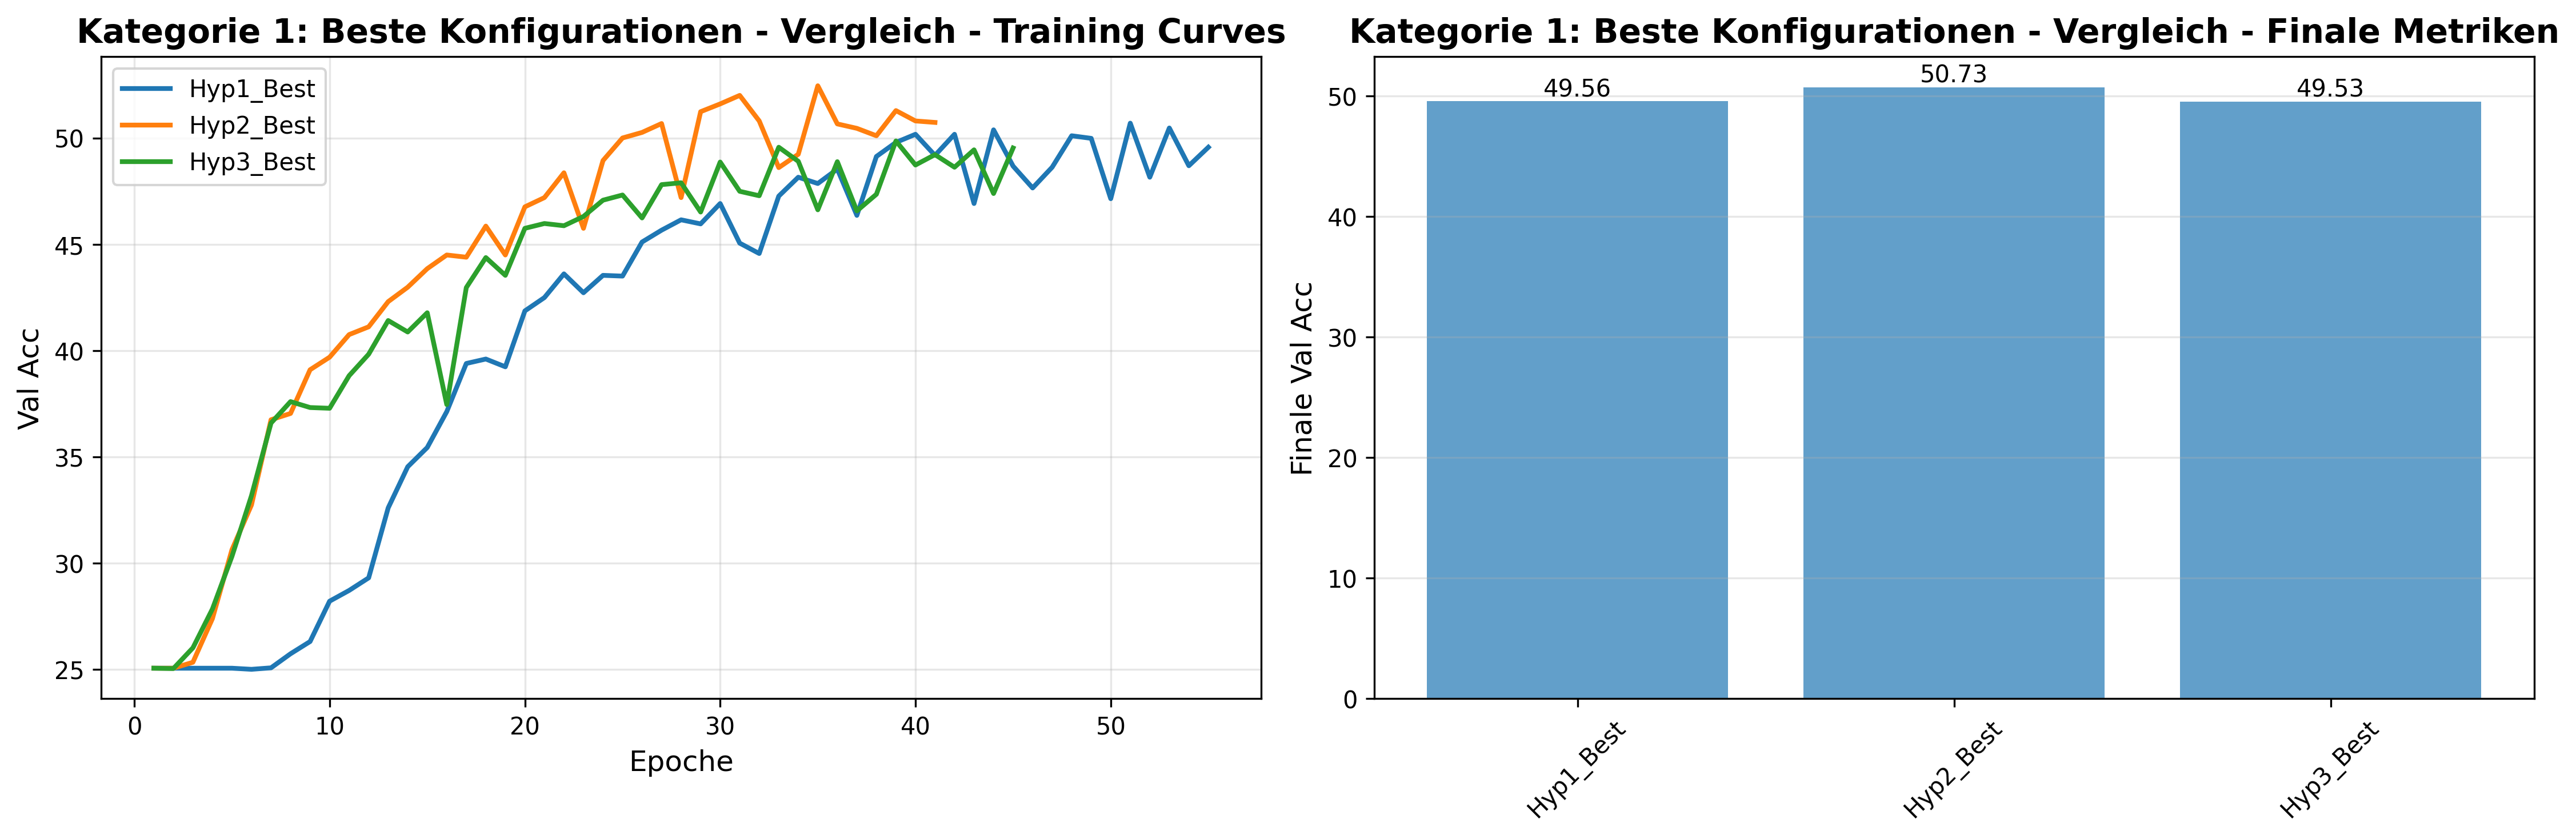

In [ ]:
# Gesamtvergleich aller Hypothesen
print("=== Zusammenfassung: Kategorie 1 - Modellkomplexität ===")

category1_file = os.path.join(results_dir, "category1_all_results.json")

if os.path.exists(category1_file):
    with open(category1_file, 'r') as f:
        category1_data = json.load(f)
    
# Beste Konfigurationen aus jeder Hypothese
    if 'summary' in category1_data:
        summary = category1_data['summary']
        print(f"\nBeste Konfigurationen pro Hypothese:")
        print(f"  Hypothese 1 (Tiefe): {summary.get('best_hyp1', 'N/A')}")
        print(f"  Hypothese 2 (Breite): {summary.get('best_hyp2', 'N/A')}")
        print(f"  Hypothese 3 (FC-Breite): {summary.get('best_hyp3', 'N/A')}")
        print(f"  Gesamtbeste: {summary.get('overall_best', 'N/A')}")
    
# Vergleichsplot anzeigen
    plot_path = "plots/experiments/category1_best_comparison.png"
    if os.path.exists(plot_path):
        print(f"\nGesamtvergleich:")
        display(Image(filename=plot_path))
    else:
        print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {category1_file}")
    print("Bitte führen Sie zuerst alle Experimente in 'hyperparameter_experiments.ipynb' durch.")

***Gesamtauswertung Kategorie 1:***

Die Auswertung nutzt dieselben **Metriken** wie in den Einzelhypothesen (Accuracy, F1-Score weighted, Loss, Overfitting-Gap Acc/F1).

- **Vergleich der Hypothesen:** Den **größten Einfluss** auf die Validation Accuracy hat die **Modellbreite** (Hypothese 2): [64,128,256] Filter erreichen **52,46 %** Val Acc und liegen damit klar vor der besten Tiefen-Variante (4 Layer, **50,70 %**) und der besten FC-Variante (128 Neuronen, **49,86 %**). Die **Tiefe** (4 Layer) bringt eine deutliche Verbesserung gegenüber der Baseline (3 Layer, 48,87 %). Die **FC-Layer-Breite** hat den geringsten Effekt auf die Val Acc, beeinflusst aber das Overfitting stark (512 Neuronen: Gap 43,9 %).

- **Optimale Konfiguration:** Die **beste Einzeländerung** ist **mehr Filter** ([64,128,256]). In den Experimenten wurde jeweils nur ein Aspekt variiert; eine **kombinierte** optimale Konfiguration (z. B. 4 Layer + [64,128,256] + 128 FC) wurde nicht getestet. Basierend auf den Einzelergebnissen wäre sie zu erwarten, würde aber voraussichtlich das Overfitting weiter erhöhen (alle „besten“ Varianten haben bereits Gap > 30 %).

- **Trade-offs:** **Performance vs. Generalisierung:** Größere Kapazität (mehr Filter, mehr Layer, mehr FC-Neuronen) steigert tendenziell die Val Acc, erhöht aber den Overfitting-Gap. **Parameter-Effizienz:** [8,16,32] (Hyp 2) und 32 FC-Neuronen (Hyp 3) bieten ein gutes Verhältnis aus Val Acc und kleinem Gap bei geringerer Parameterzahl. **Overfitting** bleibt durchgängig das zentrale Problem; alle besten Konfigurationen haben einen Train–Val-Gap von über 27 %.

- **Erkenntnisse:** (1) Modellbreite (Filteranzahl) wirkt am stärksten auf die Val Performance. (2) Moderate Tiefe (4 Layer) nützt; zu viel Tiefe (6 Layer) verschlechtert die Generalisierung. (3) Sehr große FC-Layer (512) overfitten stark. (4) Für robustere Modelle sind **Regularisierung** (Dropout, BatchNorm, Data Augmentation) und ggf. **Transfer Learning** sinnvoll, da die Komplexität allein das Overfitting nicht löst.

- **Vergleich mit Theorie:** Die Ergebnisse **stützen die theoretischen Erwartungen**: Mehr Kapazität verbessert die Performance, geht aber mit höherem Overfitting einher (Goodfellow et al.). Tiefere Netze ohne Residual Connections zeigen ab 6 Layern stärkeres Overfitting (Vanishing Gradient / Degradation). Die Bedeutung der Filteranzahl für reichere Feature-Repräsentationen (Fleuret, VGG-ähnliche Architekturen) bestätigt sich. Die Experimente liefern damit eine konsistente empirische Basis für die modellierte Modellkomplexität.

#### Kategorie 2 - Conv-Layer Settings

##### Hypothese 4: Kernel Size

**a) Hypothese:**
Größere Kernel (5×5, 7×7) erfassen größere Receptive Fields und können mehr Kontext in einem einzigen Layer erfassen. Kleinere Kernel (3×3) sind jedoch effizienter und können durch Stacking ähnliche Receptive Fields erreichen, während sie weniger Parameter benötigen.

**Begründung:** 
Die Kernel-Größe bestimmt das Receptive Field eines Neurons - den Bereich des Input-Bildes, den es "sehen" kann. Größere Kernel (z.B. 5×5 oder 7×7) ermöglichen es einem einzelnen Neuron, einen größeren Bereich des Bildes zu erfassen, was für die Erkennung größerer Muster oder Strukturen vorteilhaft sein kann.

Allerdings zeigen Simonyan & Zisserman (2014) in ihrer VGG-Architektur, dass mehrere gestapelte 3×3 Convolutions effizienter sind als eine einzige größere Convolution: Zwei 3×3 Convolutions haben das gleiche Receptive Field wie eine 5×5 Convolution, benötigen aber weniger Parameter (2×3² = 18 vs. 5² = 25 Parameter pro Filter). Drei 3×3 Convolutions entsprechen einer 7×7 Convolution, benötigen aber nur 27 statt 49 Parameter.

Wie Fleuret (2023, S. 62) erklärt, ist die Anzahl der Parameter in einer Convolution proportional zu Kernel-Größe² × Anzahl der Input-Kanäle × Anzahl der Output-Kanäle. Kleinere Kernel reduzieren daher sowohl die Parameteranzahl als auch die Rechenkosten, während sie durch Stacking ähnliche Receptive Fields erreichen können.

**Quelle:**
- Simonyan, K., & Zisserman, A. (2014). "Very Deep Convolutional Networks for Large-Scale Image Recognition." arXiv:1409.1556
- Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
3×3 Kernel sollten optimal sein, da sie durch Stacking effizient größere Receptive Fields erreichen können. 5×5 Kernel könnten ähnlich performen, sind aber ineffizienter (mehr Parameter, längere Trainingszeit). 7×7 Kernel könnten zu viele Parameter haben und Overfitting verstärken.

**b) Experiment:**

**Baseline:** 3×3 Kernel  
**Varianten:** 5×5, 7×7 Kernel (mit entsprechendem Padding, um die Ausgabegröße gleich zu halten)  
**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer, [16,32,64] Filter, MaxPool2d(2×2)

**c) Analyse:**

- Performance vs. Parameteranzahl (Trade-off visualisieren)
- Training-Zeit pro Epoche vergleichen
- Overfitting-Verhalten (Train-Val Gap analysieren)
- Effizienz: Performance pro Parameter
- Vergleich mit theoretischer Erwartung (3×3 sollte effizienter sein)

In [ ]:
# Hypothese 4 Ergebnisse laden und analysieren
print("=== Hypothese 4: Kernel Size ===")

# Ergebnisse aus JSON laden
results_dir = "results"
hyp4_file = os.path.join(results_dir, "hypothesis_4_kernel_size.json")

if os.path.exists(hyp4_file):
    with open(hyp4_file, 'r') as f:
        hyp4_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
    # Zusammenfassungstabelle (Metriken: siehe „Überblick der Metriken")
    summary_data = []
    for name, result in hyp4_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}",
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
        # Beste Konfiguration
        best_config = max(hyp4_results.items(), 
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp4_kernel_size_comparison.png",
        "plots/experiments/hyp4_complexity_analysis.png",
        "plots/experiments/hyp4_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
        else:
            print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {hyp4_file}")
    print("Bitte führen Sie zuerst die Experimente in 'training.ipynb' durch.")


##### Hypothese 5: Pooling-Strategie

**a) Hypothese:**
Average Pooling ist robuster gegen Noise und kann bessere Generalisierung zeigen, da es alle Werte im Pooling-Bereich berücksichtigt. Max Pooling betont starke Features und ist der Standard, kann aber empfindlicher auf Outlier reagieren. Adaptive Pooling könnte flexibler sein, indem es die Ausgabegröße unabhängig von der Input-Größe festlegt.

**Begründung:** 
Pooling-Layer reduzieren die räumliche Dimension der Feature-Maps und erhöhen damit die Invarianz gegenüber kleinen Translationen. Max Pooling wählt den maximalen Wert in jedem Pooling-Bereich, was dazu führt, dass starke Aktivierungen (z.B. das Vorhandensein eines bestimmten Features) erhalten bleiben. Dies ist der Standard-Ansatz in den meisten CNN-Architekturen.

Average Pooling berechnet den Durchschnitt aller Werte im Pooling-Bereich. Wie Goodfellow et al. (2016, S. 330-331) erklären, kann Average Pooling robuster gegen Noise sein, da einzelne Outlier weniger Einfluss haben. In manchen Fällen kann Average Pooling zu besserer Generalisierung führen, besonders wenn die Daten verrauscht sind.

Adaptive Pooling (z.B. AdaptiveAvgPool2d) ermöglicht es, die Ausgabegröße unabhängig von der Input-Größe festzulegen. Dies ist besonders nützlich für Transfer Learning, wo Pre-trained Modelle auf verschiedene Input-Größen angepasst werden müssen.

Fleuret (2023, S. 69) erklärt, dass Pooling die räumliche Größe reduziert und damit die Rechenkosten für nachfolgende Layer senkt, während gleichzeitig die Invarianz gegenüber kleinen Translationen erhöht wird.

**Quelle:**
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). "Deep Learning." MIT Press. Chapter 9: Convolutional Networks
- Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
Max Pooling sollte tendenziell besser performen, da es der Standard ist und starke Features betont. Average Pooling könnte jedoch weniger Overfitting zeigen und bessere Generalisierung erreichen, besonders bei verrauschten Daten. Adaptive Pooling könnte flexibler sein, aber möglicherweise keine signifikanten Vorteile bei festen Input-Größen bieten.

**b) Experiment:**

**Baseline:** MaxPool2d(2×2)  
**Varianten:** AvgPool2d(2×2), AdaptiveAvgPool2d(output_size=(6, 6))  
**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer, [16,32,64] Filter, 3×3 Kernel

**c) Analyse:**

- Generalisierung: Train-Val Gap vergleichen
- Feature-Qualität: Welche Strategie führt zu aussagekräftigeren Features?
- Robustheit: Performance bei verschiedenen Datenqualitäten
- Overfitting-Verhalten: Welche Strategie reduziert Overfitting am stärksten?

In [ ]:
# Hypothese 5 Ergebnisse laden und analysieren
print("=== Hypothese 5: Pooling-Strategie ===")

# Ergebnisse aus JSON laden
results_dir = "results"
hyp5_file = os.path.join(results_dir, "hypothesis_5_pooling.json")

if os.path.exists(hyp5_file):
    with open(hyp5_file, 'r') as f:
        hyp5_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
    # Zusammenfassungstabelle (Metriken: siehe „Überblick der Metriken")
    summary_data = []
    for name, result in hyp5_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}",
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
        # Beste Konfiguration
        best_config = max(hyp5_results.items(), 
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp5_pooling_comparison.png",
        "plots/experiments/hyp5_generalization_analysis.png",
        "plots/experiments/hyp5_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
        else:
            print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {hyp5_file}")
    print("Bitte führen Sie zuerst die Experimente in 'training.ipynb' durch.")

##### Zusammenfassung Kategorie 2: Conv-Layer Settings

**Gesamtvergleich aller Hypothesen:**

Hier werden die besten Konfigurationen aus beiden Hypothesen verglichen, um die optimale Modellkomplexität zu identifizieren.

In [ ]:
# Gesamtvergleich beider Hypothesen
print("=== Zusammenfassung: Kategorie 2 - Conv-Layer Settings ===")

category2_file = os.path.join(results_dir, "category2_all_results.json")

if os.path.exists(category2_file):
    with open(category2_file, 'r') as f:
        category2_data = json.load(f)

    if 'summary' in category2_data:
        summary = category2_data['summary']
        print(f"\nBeste Konfigurationen pro Hypothese:")
        print(f"  Hypothese 4 (Kernel Size): {summary.get('best_hyp4', 'N/A')}")
        print(f"  Hypothese 5 (Pooling-Strategie): {summary.get('best_hyp5', 'N/A')}")
        print(f"  Gesamtbeste: {summary.get('overall_best', 'N/A')}")

# Vergleichsplot anzeigen
    plot_path = "plots/experiments/category2_best_comparison.png"
    if os.path.exists(plot_path):
        print(f"\nGesamtvergleich:")
        display(Image(filename=plot_path))
    else:
        print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {category2_file}")
    print("Bitte führen Sie zuerst alle Experimente in 'training.ipynb' durch.")

#### Kategorie 3 - Regularisierung

##### Hypothese 6: Dropout

**a) Hypothese:**
Dropout reduziert Overfitting durch zufälliges Deaktivieren von Neuronen während des Trainings, was die Generalisierung verbessert. Zu hohe Dropout-Raten können jedoch das Training erschweren und die Modellkapazität zu stark reduzieren.

**Begründung:** 
Dropout ist eine Regularisierungstechnik, die während des Trainings zufällig einen Teil der Neuronen deaktiviert. Wie Srivastava et al. (2014) erklären, verhindert Dropout die Co-Adaptation von Neuronen: "Wenn ein Neuron ausfällt, muss ein anderes Neuron die Rolle übernehmen. Dies führt dazu, dass die Neuronen robuster werden und nicht zu stark von anderen Neuronen abhängen."

Die Dropout-Rate bestimmt den Anteil der deaktivierten Neuronen. Eine zu niedrige Rate (z.B. 0.1) hat kaum Effekt, während eine zu hohe Rate (z.B. 0.7) das Modell zu stark einschränkt und das Training erschwert. In der Praxis haben sich Dropout-Raten zwischen 0.3 und 0.5 als effektiv erwiesen.

Fleuret (2023, S. 88-89) erklärt, dass Dropout während des Trainings als Ensemble-Methode interpretiert werden kann: Bei jedem Forward-Pass wird ein anderes Subnetzwerk trainiert, und während der Inferenz werden alle Neuronen aktiviert, was einem gewichteten Durchschnitt aller trainierten Subnetzwerke entspricht.

**Quelle:**
- Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). "Dropout: A Simple Way to Prevent Neural Networks from Overfitting." Journal of Machine Learning Research, 15, 1929-1958.
- Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
Dropout mit Raten von 0.3-0.5 sollte Overfitting reduzieren und die Validation Accuracy verbessern, besonders bei den FC-Layern, wo die meisten Parameter sitzen. Dropout nach Conv-Layern könnte ebenfalls helfen, aber möglicherweise weniger effektiv sein. Zu hohe Dropout-Raten (0.5+) könnten das Training erschweren.

**b) Experiment:**

**Baseline:** Kein Dropout  
**Varianten:** 
- Dropout(0.2) nach Conv-Layern
- Dropout(0.3) nach Conv-Layern
- Dropout(0.3) nach FC-Layern
- Dropout(0.5) nach FC-Layern
- Dropout(0.3) nach Conv- und FC-Layern (kombiniert)

**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer, [16,32,64] Filter, 3×3 Kernel, MaxPool2d(2×2)

**c) Analyse:**

- Train-Val Gap: Reduziert Dropout das Overfitting?
- Finale Val-Accuracy: Verbessert Dropout die Generalisierung?
- Training-Stabilität: Wie beeinflusst Dropout die Konvergenz?
- Optimaler Dropout-Ort: Conv-Layer vs. FC-Layer vs. kombiniert

In [ ]:
# Hypothese 6 Ergebnisse laden und analysieren
print("=== Hypothese 6: Dropout ===")

# Ergebnisse aus JSON laden
results_dir = "results"
hyp6_file = os.path.join(results_dir, "hypothesis_6_dropout.json")

if os.path.exists(hyp6_file):
    with open(hyp6_file, 'r') as f:
        hyp6_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
    # Zusammenfassungstabelle (Metriken: siehe „Überblick der Metriken")
    summary_data = []
    for name, result in hyp6_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}",
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
        # Beste Konfiguration
        best_config = max(hyp6_results.items(), 
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp6_dropout_comparison.png",
        "plots/experiments/hyp6_overfitting_analysis.png",
        "plots/experiments/hyp6_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
        else:
            print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {hyp6_file}")
    print("Bitte führen Sie zuerst die Experimente in 'training.ipynb' durch.")

##### Hypothese 7: Data Augmentation

**a) Hypothese:**
Data Augmentation (Rotation, Translation, Flip) erhöht die Datenvielfalt und verbessert die Generalisierung, reduziert Overfitting. Moderate Augmentation sollte die Val-Accuracy verbessern, während zu aggressive Augmentation das Training erschweren könnte.

**Begründung:** 
Data Augmentation erweitert den Trainingsdatensatz durch synthetische Transformationen der vorhandenen Daten. Wie Shorten & Khoshgoftaar (2019) erklären, ist Data Augmentation eine der effektivsten Methoden zur Verbesserung der Generalisierung, besonders bei kleinen Datensätzen.

Die verschiedenen Augmentation-Techniken haben unterschiedliche Effekte:
- **Rotation:** Erhöht die Invarianz gegenüber Orientierungsänderungen, was für Gesichtsausdrücke relevant ist, da Gesichter in verschiedenen Winkeln aufgenommen werden können.
- **Horizontal Flip:** Verdoppelt effektiv die Datenmenge und erhöht die Invarianz gegenüber Spiegelungen (wichtig für symmetrische Gesichtsausdrücke).
- **Translation:** Erhöht die Robustheit gegenüber leichten Verschiebungen der Gesichtsposition im Bild.

Fleuret (2023, S. 85-86) erklärt, dass Data Augmentation als implizite Regularisierung wirkt: "Indem wir das Modell mit mehr Variationen der Daten trainieren, zwingen wir es, robustere Features zu lernen, die invariant gegenüber diesen Transformationen sind."

Allerdings warnt Shorten & Khoshgoftaar (2019) vor zu aggressiver Augmentation: Wenn die Transformationen zu stark sind, können sie die semantische Bedeutung der Daten verändern (z.B. ein auf den Kopf gestelltes Gesicht ist kein Gesicht mehr) und das Training erschweren.

**Quelle:**
- Shorten, C., & Khoshgoftaar, T. M. (2019). "A survey on Image Data Augmentation for Deep Learning." Journal of Big Data, 6(1), 60.
- Fleuret, F. (2023). "The Little Book of Deep Learning." University of Geneva. https://fleuret.org/public/lbdl.pdf

**Erwartung:** 
Moderate Augmentation (Rotation ±10°, Horizontal Flip, Translation ±10%) sollte die Val-Accuracy verbessern und das Overfitting reduzieren. Eine Kombination mehrerer Techniken könnte noch bessere Ergebnisse liefern. Zu aggressive Augmentation (z.B. Rotation ±30°) könnte das Training erschweren und die Performance verschlechtern.

**b) Experiment:**

**Baseline:** Keine Augmentation  
**Varianten:**
- Rotation(±10°)
- Horizontal Flip
- Translation(±10%)
- Kombination: Rotation(±10°) + Horizontal Flip + Translation(±10%)

**Alle anderen Parameter gleich:** LR=0.01, Batch=64, 60 Epochen, 3 Conv-Layer, [16,32,64] Filter, 3×3 Kernel, MaxPool2d(2×2), kein Dropout

**c) Analyse:**

- Generalisierung: Verbessert Augmentation die Val-Accuracy?
- Train-Val Gap: Reduziert Augmentation das Overfitting?
- Robustheit: Welche Augmentation-Techniken sind am effektivsten?
- Kombinationseffekte: Ist die Kombination mehrerer Techniken besser als einzelne?

In [ ]:
# Hypothese 7 Ergebnisse laden und analysieren
print("=== Hypothese 7: Data Augmentation ===")

# Ergebnisse aus JSON laden
results_dir = "results"
hyp7_file = os.path.join(results_dir, "hypothesis_7_data_augmentation.json")

if os.path.exists(hyp7_file):
    with open(hyp7_file, 'r') as f:
        hyp7_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")
    
    # Zusammenfassungstabelle (Metriken: siehe „Überblick der Metriken")
    summary_data = []
    for name, result in hyp7_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}",
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
        # Beste Konfiguration
        best_config = max(hyp7_results.items(), 
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp7_augmentation_comparison.png",
        "plots/experiments/hyp7_generalization_analysis.png",
        "plots/experiments/hyp7_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
        else:
            print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {hyp7_file}")
    print("Bitte führen Sie zuerst die Experimente in 'training.ipynb' durch.")

##### Zusammenfassung Kategorie 3: Regularisierung

***Gesamtauswertung Kategorie 2:***

Die Auswertung nutzt dieselben **Metriken** wie in den Einzelhypothesen (Accuracy, F1-Score weighted, Loss, Overfitting-Gap Acc/F1).

In [ ]:
# Gesamtvergleich aller Hypothesen
print("=== Zusammenfassung: Kategorie 3 - Regularisierung ===")

category3_file = os.path.join(results_dir, "category3_all_results.json")

if os.path.exists(category3_file):
    with open(category3_file, 'r') as f:
        category3_data = json.load(f)

    if 'summary' in category3_data:
        summary = category3_data['summary']
        print(f"\nBeste Konfigurationen pro Hypothese:")
        print(f"  Hypothese 6 (Dropout): {summary.get('best_hyp6', 'N/A')}")
        print(f"  Hypothese 7 (Data Augmentation): {summary.get('best_hyp7', 'N/A')}")
        print(f"  Gesamtbeste: {summary.get('overall_best', 'N/A')}")

# Vergleichsplot anzeigen
    plot_path = "plots/experiments/category3_best_comparison.png"

    if os.path.exists(plot_path):
        print(f"\nGesamtvergleich:")
        display(Image(filename=plot_path))
    else:
        print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {category3_file}")
    print("Bitte führen Sie zuerst alle Experimente in 'training.ipynb' durch.")


#### Kategorie 4 - BatchNorm

##### Hypothese 8: BatchNorm

In [ ]:
# Hypothese 8 Ergebnisse laden und analysieren
print("=== Hypothese 8: BatchNorm ===")

# Ergebnisse aus JSON laden
results_dir = "results"
hyp8_file = os.path.join(results_dir, "hypothesis_8_batchnorm.json")

if os.path.exists(hyp8_file):
    with open(hyp8_file, 'r') as f:
        hyp8_results = json.load(f)
    
    print("\nErgebnisse geladen. Zusammenfassung:")

    # Zusammenfassungstabelle 
    summary_data = []
    for name, result in hyp8_results.items():
        if isinstance(result, dict) and 'final_val_acc' in result:
            summary_data.append({
                'Konfiguration': name,
                'Parameter': f"{result.get('num_params', 0):,}",
                'Beste Val Acc (%)': f"{result.get('best_val_acc', 0):.2f}",
                'Finale Val Acc (%)': f"{result.get('final_val_acc', 0):.2f}",
                'Beste Val F1': f"{result.get('best_val_f1', 0):.4f}",
                'Finale Val F1': f"{result.get('final_val_f1', 0):.4f}",
                'Final Val Loss': f"{result.get('final_val_loss', 0):.4f}", 
                'Overfitting-Gap Acc (%)': f"{result.get('overfitting_gap_acc', 0):.2f}",
                'Overfitting-Gap F1': f"{result.get('overfitting_gap_f1', 0):.4f}",
                'Beste Epoche': result.get('best_epoch', 0)
            })
    
    if summary_data:    
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        
        # Beste Konfiguration
        best_config = max(hyp8_results.items(), 
                         key=lambda x: x[1].get('best_val_acc', 0) if isinstance(x[1], dict) else 0)
        print(f"\nBeste Konfiguration: {best_config[0]}")
        if isinstance(best_config[1], dict):
            print(f"  Beste Val Acc: {best_config[1].get('best_val_acc', 0):.2f}%")
            print(f"  Parameter: {best_config[1].get('num_params', 0):,}")
    
    # Plots anzeigen
    plot_paths = [
        "plots/experiments/hyp8_batchnorm_comparison.png",
        "plots/experiments/hyp8_generalization_analysis.png",
        "plots/experiments/hyp8_training_curves.png"
    ]
    
    for plot_path in plot_paths:
        if os.path.exists(plot_path):
            print(f"\n{os.path.basename(plot_path)}:")
            display(Image(filename=plot_path))
        else:
            print(f"\nPlot nicht gefunden: {plot_path}")
else:
    print(f"Ergebnisse nicht gefunden: {hyp8_file}")
    print("Bitte führen Sie zuerst die Experimente in 'training.ipynb' durch.")
        